In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# CHANGE THE DEVICE TO WHATEVER YOU WISH TO USE
device = 'cuda:7'
print (device)

print (os.getcwd())

print(torch.__version__)

from dennytools.silence import *
from Modules.conv import Convolutor

cuda:7
/home/tbjackso/NeoNeo
1.2.0


In [2]:
BS = 100

# Training dataset
train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)


# Smaller batch size datasets (to avoid out of memory issues)
# Training dataset
train20 = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=20, shuffle=True, pin_memory=False)

# Test dataset
test20 = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=20, shuffle=True, pin_memory=False)

In [3]:
# Helper functions for displaying means and activation patterns

def plotMeans(pi, mu, N=None, shape=(28,28)):
    
    shape = (-1,)+shape
    pi = pi.squeeze()
    mu = mu.squeeze()
    vp,pp = pi.sort(descending=True)
#     print (pp)
    print (vp)
    
    if (N is None):
        N = pi.shape[0]

    pmu = mu[pp].view(shape).detach().cpu()
    rows = N//5

    fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
    for i in range(N):
        px = i//5
        py = i%5
        ax[px,py].imshow(pmu[i], cmap='gray', vmin=0, vmax=1)
    plt.show()
    

def plotActivation(data, model):

#     data = data.to(device)
    Y = model(data).cpu()
    (pi, mu) = model.params(sort=False)
    pi = pi.squeeze()
    mu = mu.squeeze()
    vp,pp = pi.sort(descending=True)

    N =  Y.shape[1]
    rows = N//5
    Yshape = Y.shape[2:]

    for j in range(1):
        plt.imshow(data[j,0].cpu(), cmap='gray', vmin=0, vmax=1)
        plt.show()
        if (Yshape[0]*Yshape[1] == 1):
            plt.imshow(Y[j,:,0,0].view(rows,5))
            plt.show()
        else:
            fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
            for i in range(N):
                px = i//5
                py = i%5
                ax[px,py].imshow(Y[j,pp[i]], cmap='gray')#, vmin=0, vmax=1)
            plt.show()


In [5]:

class EMMB(nn.Module):
    def __init__(self, D, M, eta=0.95, FF=None):
        super().__init__()
        self.register_buffer('D', torch.tensor(D))
        self.register_buffer('M', torch.tensor(M))
        
        self.pi = nn.Parameter(torch.ones((1,M))/M, requires_grad=False)
        self.mu = nn.Parameter(torch.rand((1,M,D)), requires_grad=False)
        
        self.FF = nn.Softmax(dim=-1) if FF is None else FF
        
    def responsibility(self, x, raw=False, verbose=False):
        with silence(not verbose):
            print ('x', torch.isnan(x).sum()>0)
            print ('pi', torch.isnan(self.pi).sum()>0)
            print ('mu', torch.isnan(self.mu).sum()>0)
            # Negative Log Liklihood of the multinoulis
            logpi = torch.log(self.pi+1e-18)
            print ('logpi',torch.isnan(logpi).sum()>0)
            logmu = torch.log(self.mu+1e-18)
            print ('logmu',torch.isnan(logmu).sum()>0)
            logommu = torch.log(1-self.mu+1e-18)
            print ('logommu',torch.isnan(logommu).sum()>0)
            mix_log_probs = (logpi + (x*logmu + (1-x)*logommu).sum(-1))
            print ('mix_log_probs', torch.isnan(mix_log_probs).sum()>0)
            resp = F.softmax(mix_log_probs, dim=-1)
            print ('resp', torch.isnan(resp).sum()>0)

        if (raw):
            return mix_log_probs
        return resp
        
    def forward(self, x):
        x = x.view(-1,1,self.D)
        y = self.responsibility(x, raw=True)
        return self.FF(y)
        
    def learn(self, x):
        x = x.view(-1,1,self.D)
        
        # This learns via EM algorithm
        # E step: calculates the responsibility of each mode for each point
        # M step: calculates the pis and mus
        rik = self.responsibility(x)
        if (torch.isnan(rik).sum()>0):
            self.responsibility(x, verbose=True)
            raise ValueError("NaN Found")
        rk = rik.sum(0, keepdim=True)
        # rik:  (BS, M) -> (BS, M, 1)
        newmu = (rik.unsqueeze(-1)*x).sum(0, keepdim=True)/(rk.unsqueeze(-1)+1e-18)
        newpi = rk/x.shape[0]
        
        # The M update
        self.pi.data = eta*self.pi.data + (1-eta)*newpi
        self.mu.data = eta*self.mu.data + (1-eta)*newmu
        
    def params(self, sort=True):
        pi = self.pi.squeeze()
        mu = self.mu.squeeze()
        if (sort):
            pi, pin = pi.sort(descending=True)
            mu = mu[pin]
        return (pi, mu)
    
# The Convolutor class is in Modules/conv.py and provides a base class for convolutionalizing 
# operations

class CEMMB(Convolutor):
    def __init__(self, in_size, filters, kernel_size, stride=1, eta=0.95, FF=None):
        super().__init__(in_size, filters, kernel_size, stride=stride)
        self.Process = EMMB(self.D, filters, eta=eta, FF=FF)
        
        self.register_buffer('M', torch.tensor(filters))
        
    def forward(self, x):
        (bs,c,h,w) = x.shape
        x1 = self.unfold_input(x)
        yuf = self.Process(x1)
        y = self.fold_forward(yuf, bs)
        return y
    
    def learn(self, x):
        x1 = self.unfold_input(x)
        self.Process.learn(x1)
    
    def params(self, reshape=False, sort=True):
        (pi, mu) =  self.Process.params(sort)
        mss = mu.shape
        if (reshape):
            mss = (self.F, self.C)+self.K
        return (pi, mu.view(mss))
        

In [6]:
# So now we need to find what each mode corresponds to most frequently
# Then we could run through the data again but since we have the statistics here,
# We can figure out what the probabilities are. 

# Basically, for each sample we have recorded how many times a particular mode was
# activated for it


def freqMap(dataset, classes, model, device='cpu', soft=True):
    result = torch.zeros((classes, model.M))
    for (data, label) in dataset:
        data = data.to(device)
        Y = model(data).squeeze().cpu()
        YM = torch.argmax(Y, dim=1)
        for i in range(Y.shape[0]):
            if (soft):
                result[label[i]] += Y[i]
            else:
                result[label[i],YM[i]] += 1
                
    return result

def constructLabels(result):
    return torch.argmax(result, dim=0)

def calcAcc(result, labels):
    correct = 0
    for i in range(labels.shape[0]):
        correct += result[labels[i],i].item()
        
    return correct/result.sum().item()

def evalModel(dataset, classes, model, labels=None, device=device, soft=True):
    result = freqMap(dataset, classes, model, device=device, soft=soft)
    if (labels is None):
        labels = constructLabels(result)
    accuracy = calcAcc(result, labels)
    return (accuracy, labels, result)

def pptestresults(tests, testresults):
    for i,r in enumerate(testresults):
        pre, post = r
        print ("layers: {} | {:.2f}/{:.2f} -> {:.2f}/{:.2f} | {}".format(len(tests[i][1]),100*pre[0],100*pre[1],100*post[0],100*post[1], tests[i]))

tensor([0.0409, 0.0373, 0.0369, 0.0363, 0.0356, 0.0321, 0.0312, 0.0297, 0.0295,
        0.0293, 0.0287, 0.0282, 0.0276, 0.0275, 0.0266, 0.0262, 0.0259, 0.0257,
        0.0249, 0.0247, 0.0245, 0.0238, 0.0226, 0.0223, 0.0221, 0.0219, 0.0214,
        0.0214, 0.0213, 0.0213, 0.0205, 0.0203, 0.0199, 0.0193, 0.0178, 0.0176,
        0.0173, 0.0140, 0.0130, 0.0130])


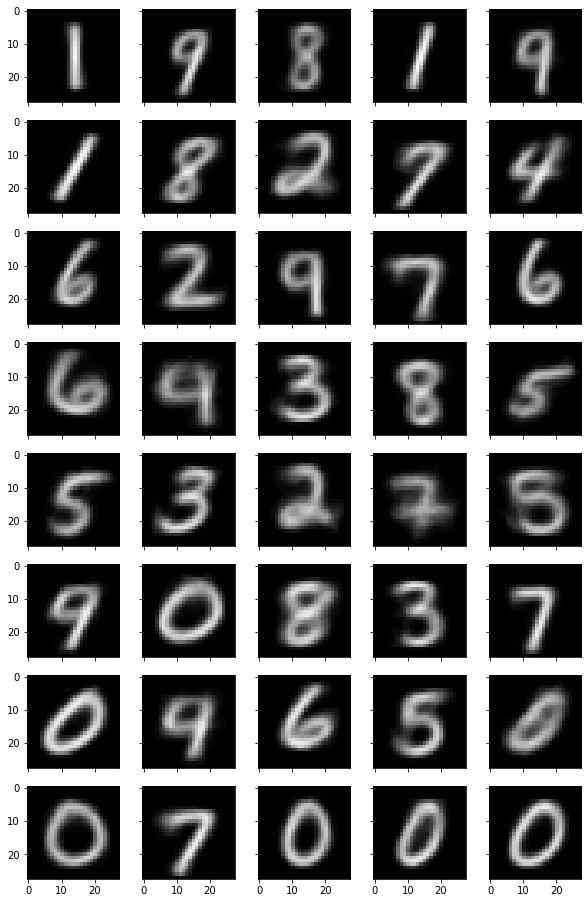

tensor([0.0405, 0.0356, 0.0350, 0.0333, 0.0319, 0.0308, 0.0302, 0.0289, 0.0286,
        0.0285, 0.0285, 0.0283, 0.0282, 0.0281, 0.0279, 0.0278, 0.0269, 0.0269,
        0.0263, 0.0263, 0.0260, 0.0252, 0.0251, 0.0245, 0.0223, 0.0221, 0.0220,
        0.0219, 0.0211, 0.0205, 0.0204, 0.0204, 0.0202, 0.0199, 0.0181, 0.0176,
        0.0148, 0.0136, 0.0134, 0.0123])


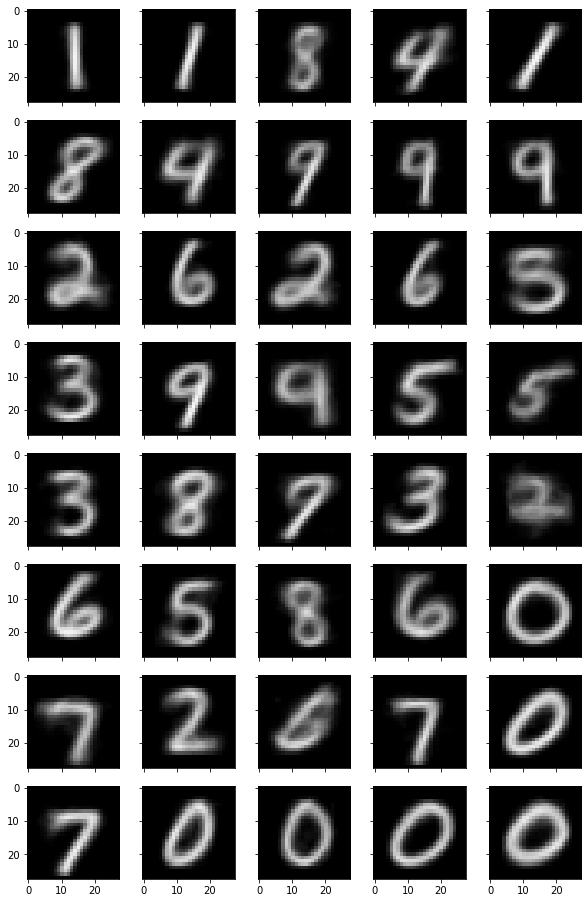

tensor([0.0452, 0.0391, 0.0340, 0.0329, 0.0323, 0.0318, 0.0309, 0.0303, 0.0303,
        0.0299, 0.0296, 0.0295, 0.0287, 0.0286, 0.0276, 0.0272, 0.0260, 0.0259,
        0.0253, 0.0242, 0.0239, 0.0235, 0.0232, 0.0230, 0.0214, 0.0212, 0.0206,
        0.0204, 0.0203, 0.0203, 0.0194, 0.0194, 0.0193, 0.0193, 0.0188, 0.0173,
        0.0159, 0.0154, 0.0153, 0.0128])


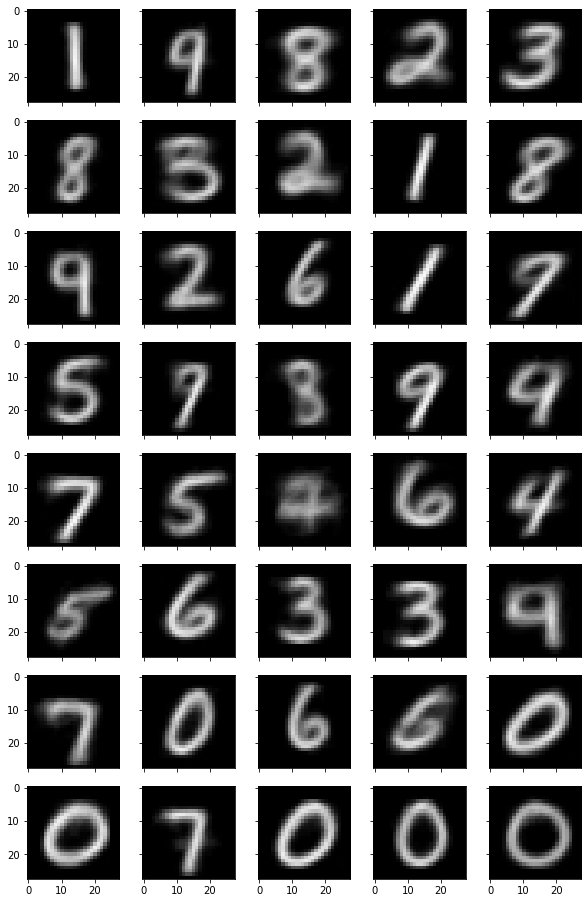

tensor([0.0446, 0.0424, 0.0385, 0.0358, 0.0332, 0.0316, 0.0312, 0.0293, 0.0282,
        0.0276, 0.0272, 0.0270, 0.0267, 0.0266, 0.0266, 0.0264, 0.0260, 0.0255,
        0.0255, 0.0250, 0.0250, 0.0245, 0.0244, 0.0242, 0.0237, 0.0236, 0.0216,
        0.0216, 0.0209, 0.0188, 0.0185, 0.0182, 0.0180, 0.0180, 0.0178, 0.0174,
        0.0173, 0.0149, 0.0144, 0.0124])


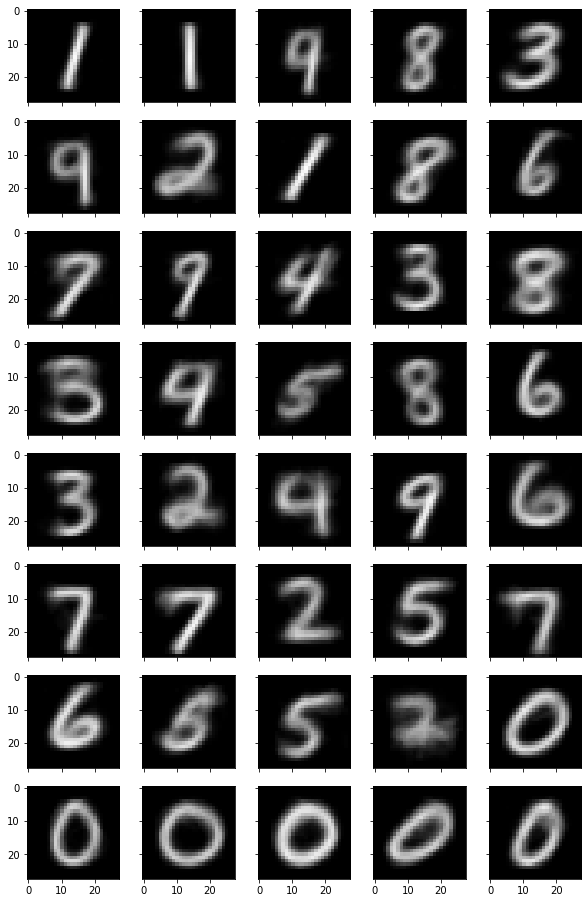

tensor([0.0394, 0.0390, 0.0368, 0.0367, 0.0347, 0.0335, 0.0314, 0.0310, 0.0300,
        0.0287, 0.0282, 0.0278, 0.0276, 0.0268, 0.0259, 0.0255, 0.0252, 0.0246,
        0.0244, 0.0240, 0.0233, 0.0232, 0.0228, 0.0227, 0.0221, 0.0216, 0.0213,
        0.0211, 0.0209, 0.0208, 0.0202, 0.0201, 0.0196, 0.0194, 0.0193, 0.0182,
        0.0175, 0.0160, 0.0150, 0.0135])


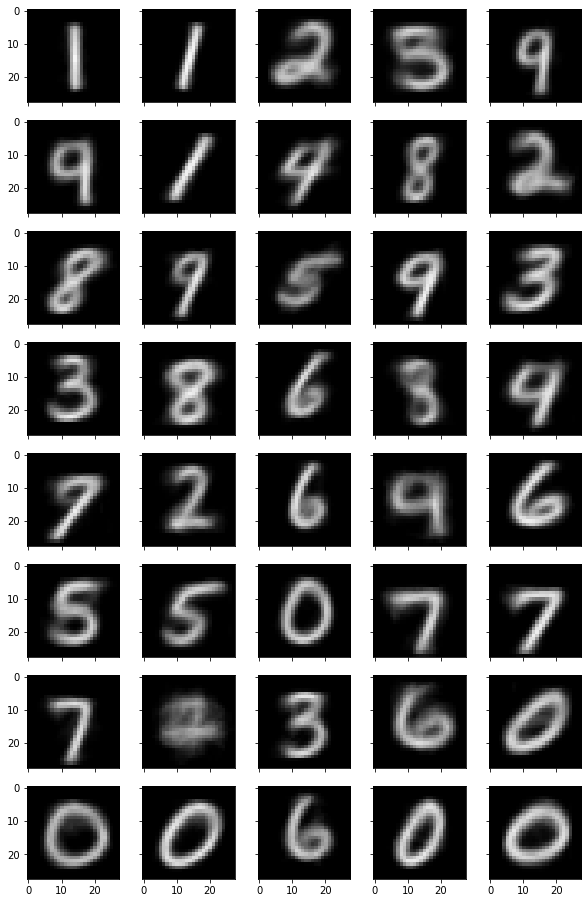

In [14]:
M = 40
D = 784
epochs = 5
eta = 0.95

model = EMMB(D, M, eta)

for e in range(epochs):
    for (data, label) in train:
        model.learn(data)
    (pi, mu) = model.params()
    plotMeans(pi, mu)
        

#############################################
Kernel Size: (2,2)
tensor([0.1121, 0.0866, 0.0842, 0.0631, 0.0570, 0.0406, 0.0373, 0.0343, 0.0334,
        0.0322, 0.0275, 0.0259, 0.0242, 0.0237, 0.0234, 0.0189, 0.0187, 0.0166,
        0.0162, 0.0159, 0.0145, 0.0139, 0.0134, 0.0130, 0.0129, 0.0127, 0.0124,
        0.0118, 0.0117, 0.0113, 0.0110, 0.0108, 0.0096, 0.0094, 0.0091, 0.0079,
        0.0070, 0.0061, 0.0054, 0.0043], device='cuda:7')


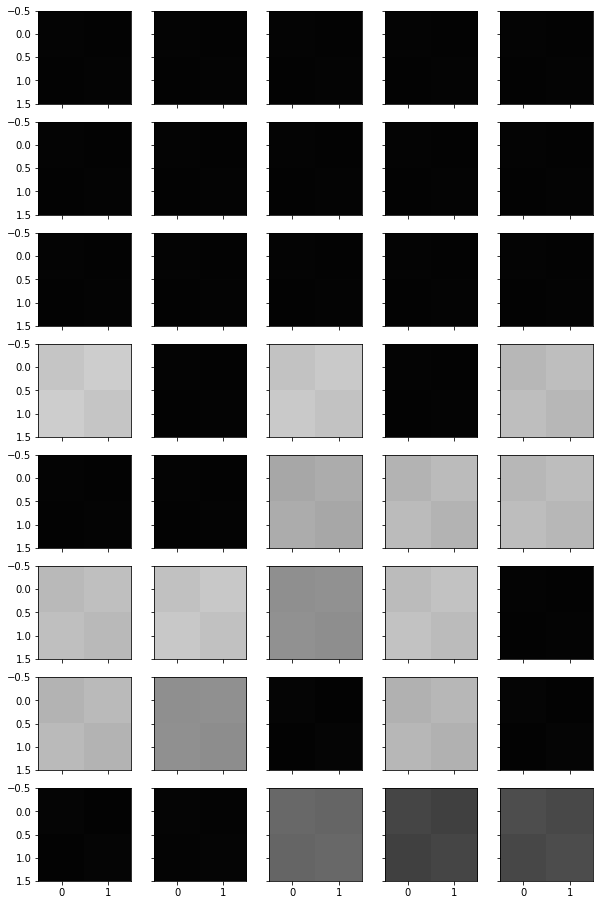

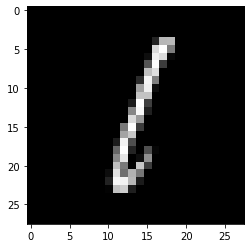

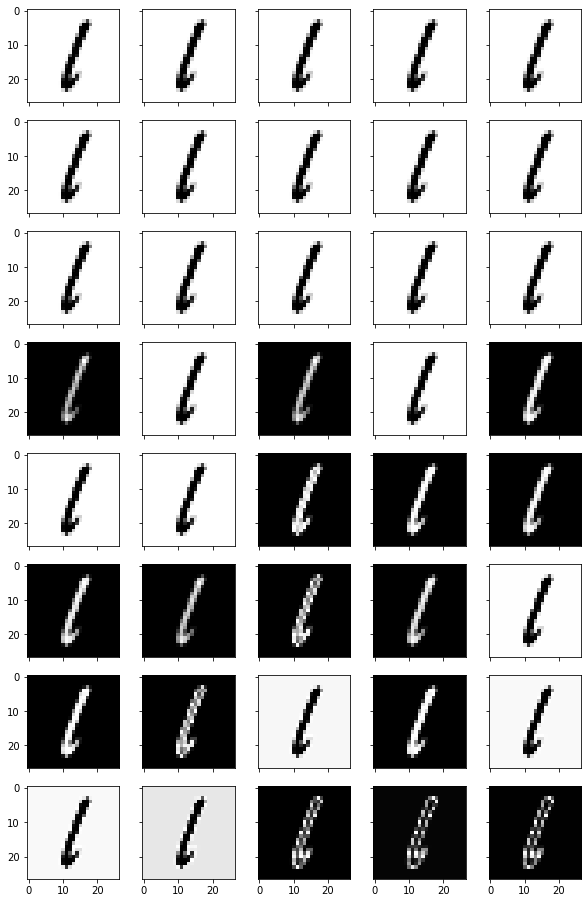

#############################################
Kernel Size: (3,3)
tensor([0.2730, 0.1770, 0.0872, 0.0604, 0.0270, 0.0243, 0.0208, 0.0207, 0.0202,
        0.0193, 0.0170, 0.0166, 0.0142, 0.0140, 0.0139, 0.0138, 0.0124, 0.0100,
        0.0097, 0.0096, 0.0092, 0.0086, 0.0082, 0.0080, 0.0080, 0.0080, 0.0079,
        0.0077, 0.0075, 0.0074, 0.0072, 0.0069, 0.0069, 0.0068, 0.0068, 0.0065,
        0.0065, 0.0058, 0.0033, 0.0017], device='cuda:7')


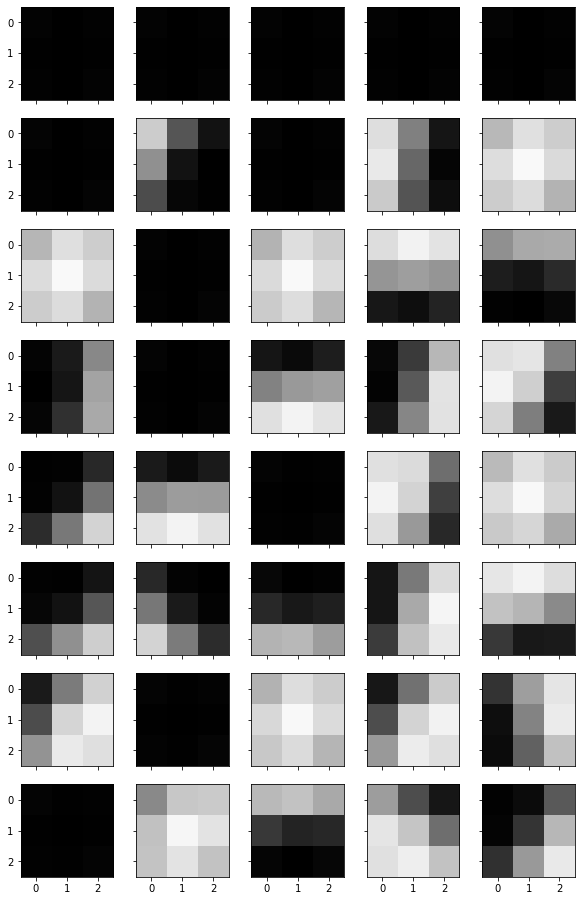

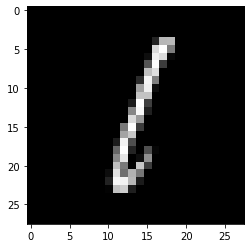

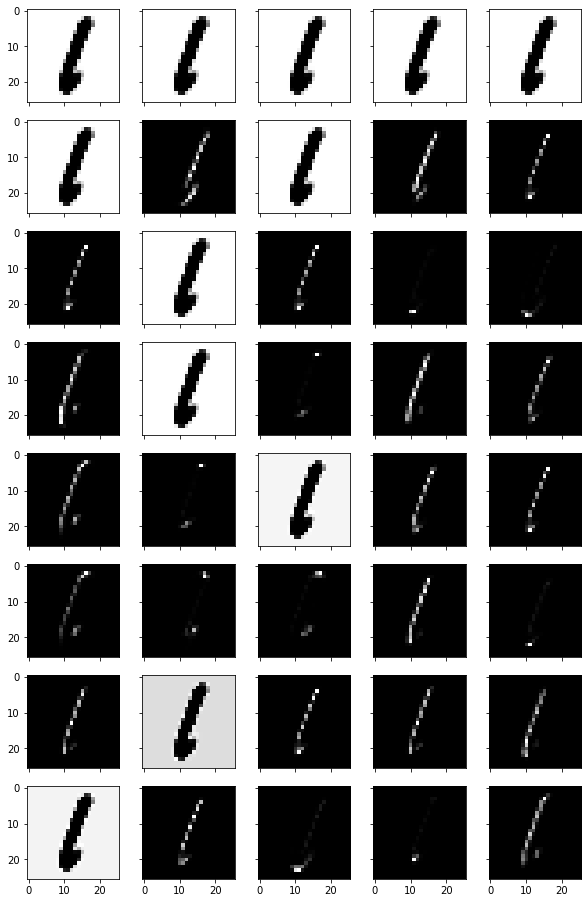

#############################################
Kernel Size: (4,4)
tensor([0.6100, 0.0205, 0.0185, 0.0161, 0.0148, 0.0147, 0.0142, 0.0140, 0.0136,
        0.0135, 0.0133, 0.0130, 0.0128, 0.0126, 0.0124, 0.0120, 0.0116, 0.0108,
        0.0105, 0.0104, 0.0103, 0.0095, 0.0090, 0.0087, 0.0081, 0.0080, 0.0080,
        0.0079, 0.0070, 0.0066, 0.0065, 0.0065, 0.0064, 0.0063, 0.0055, 0.0054,
        0.0049, 0.0039, 0.0011, 0.0010], device='cuda:7')


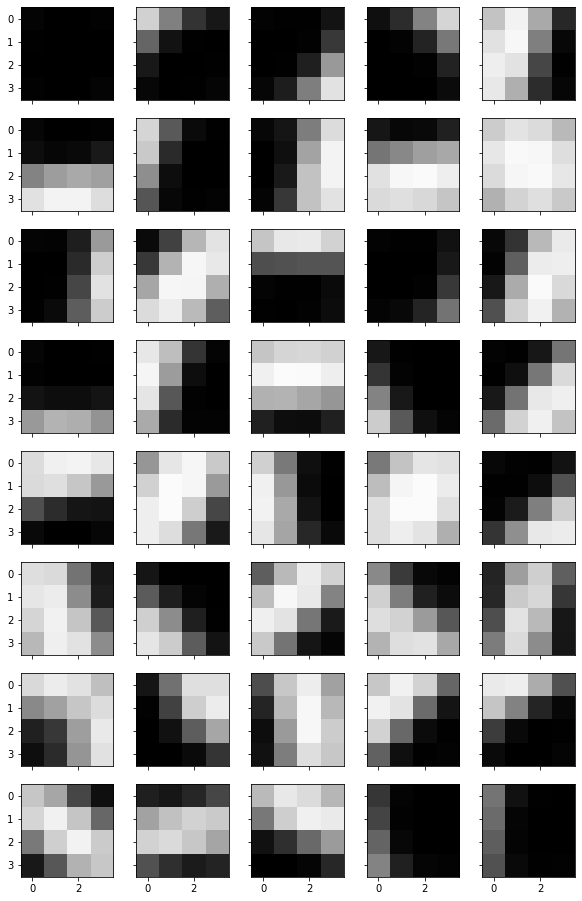

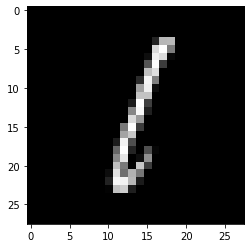

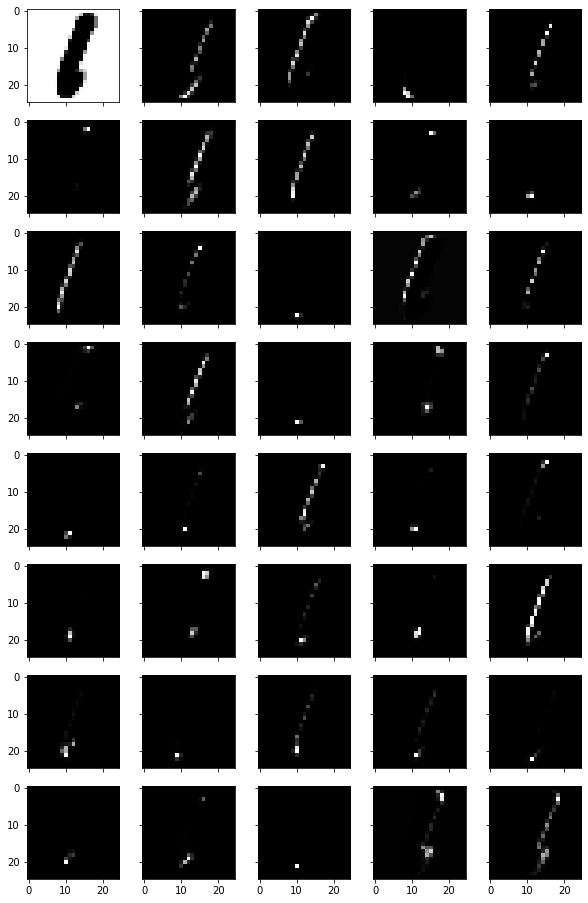

#############################################
Kernel Size: (5,5)
tensor([0.5147, 0.0330, 0.0315, 0.0228, 0.0195, 0.0189, 0.0164, 0.0159, 0.0150,
        0.0146, 0.0142, 0.0140, 0.0136, 0.0135, 0.0133, 0.0131, 0.0130, 0.0125,
        0.0124, 0.0116, 0.0108, 0.0106, 0.0102, 0.0099, 0.0098, 0.0097, 0.0090,
        0.0090, 0.0086, 0.0085, 0.0085, 0.0084, 0.0083, 0.0079, 0.0079, 0.0070,
        0.0061, 0.0060, 0.0056, 0.0047], device='cuda:7')


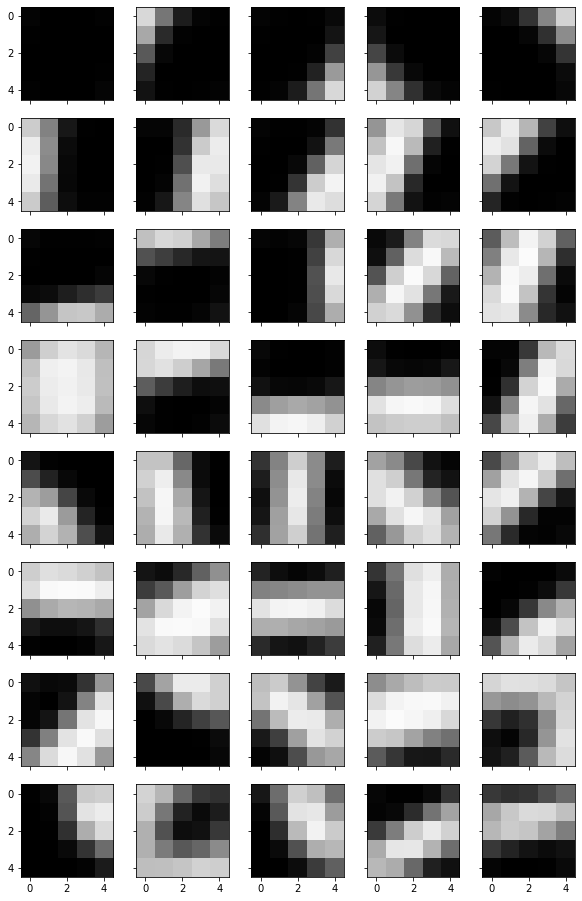

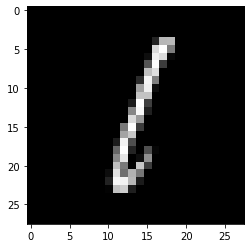

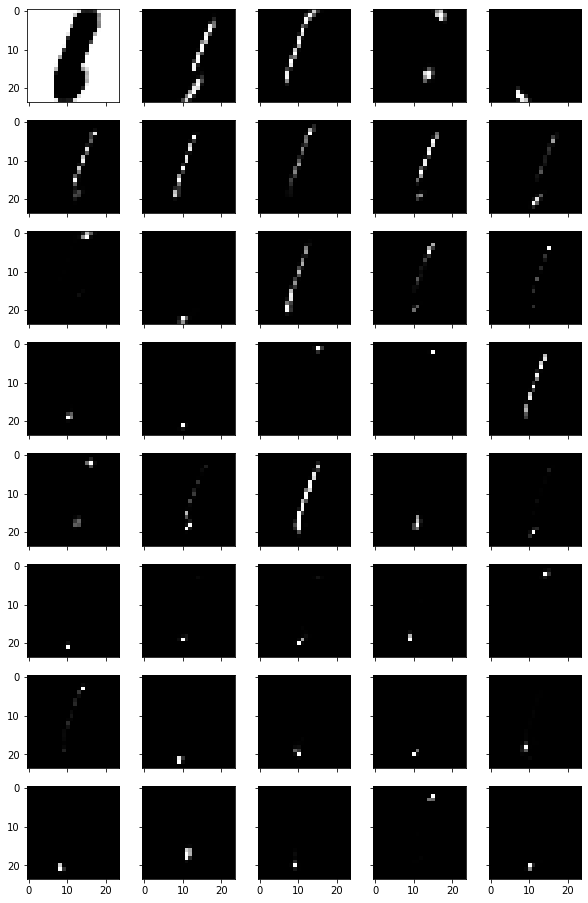

#############################################
Kernel Size: (6,6)
tensor([0.3711, 0.0455, 0.0416, 0.0412, 0.0266, 0.0245, 0.0223, 0.0219, 0.0208,
        0.0208, 0.0197, 0.0189, 0.0176, 0.0169, 0.0155, 0.0152, 0.0149, 0.0144,
        0.0141, 0.0138, 0.0134, 0.0125, 0.0124, 0.0124, 0.0110, 0.0110, 0.0108,
        0.0103, 0.0103, 0.0102, 0.0101, 0.0101, 0.0100, 0.0093, 0.0092, 0.0090,
        0.0089, 0.0088, 0.0068, 0.0062], device='cuda:7')


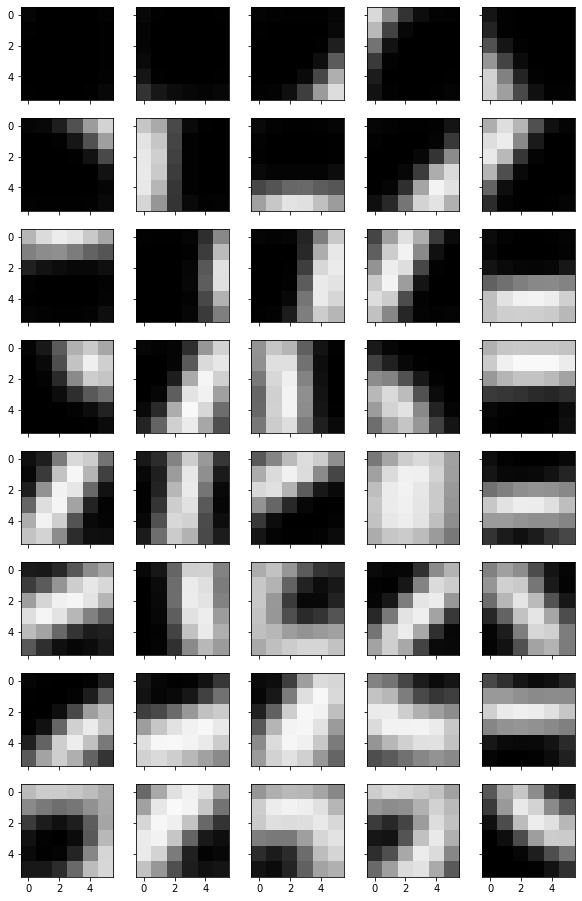

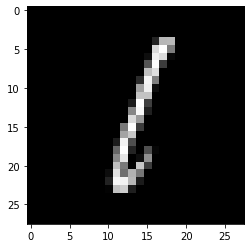

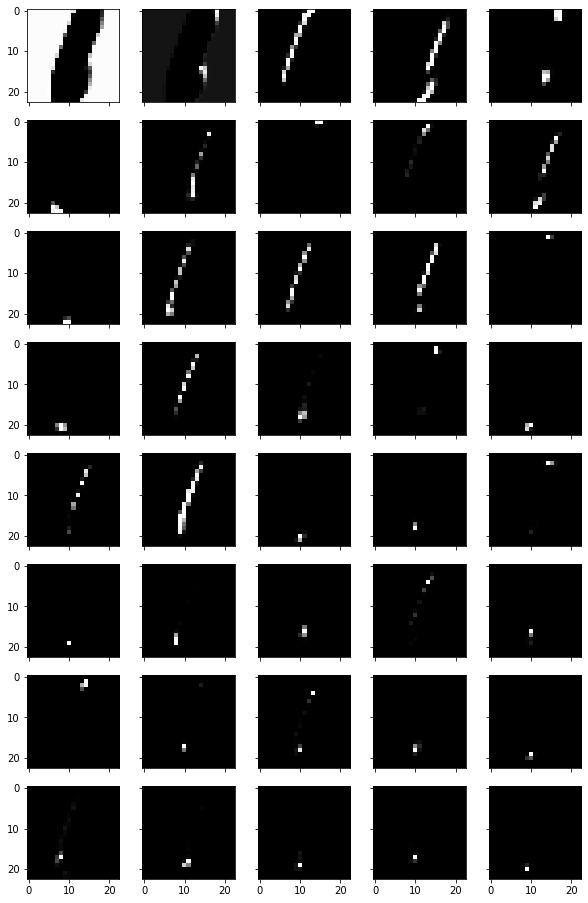

#############################################
Kernel Size: (7,7)
tensor([0.3107, 0.0532, 0.0363, 0.0358, 0.0350, 0.0293, 0.0284, 0.0253, 0.0233,
        0.0220, 0.0219, 0.0219, 0.0205, 0.0196, 0.0195, 0.0192, 0.0191, 0.0179,
        0.0163, 0.0160, 0.0143, 0.0142, 0.0135, 0.0126, 0.0123, 0.0121, 0.0116,
        0.0116, 0.0109, 0.0108, 0.0107, 0.0093, 0.0092, 0.0090, 0.0089, 0.0082,
        0.0081, 0.0079, 0.0075, 0.0061], device='cuda:7')


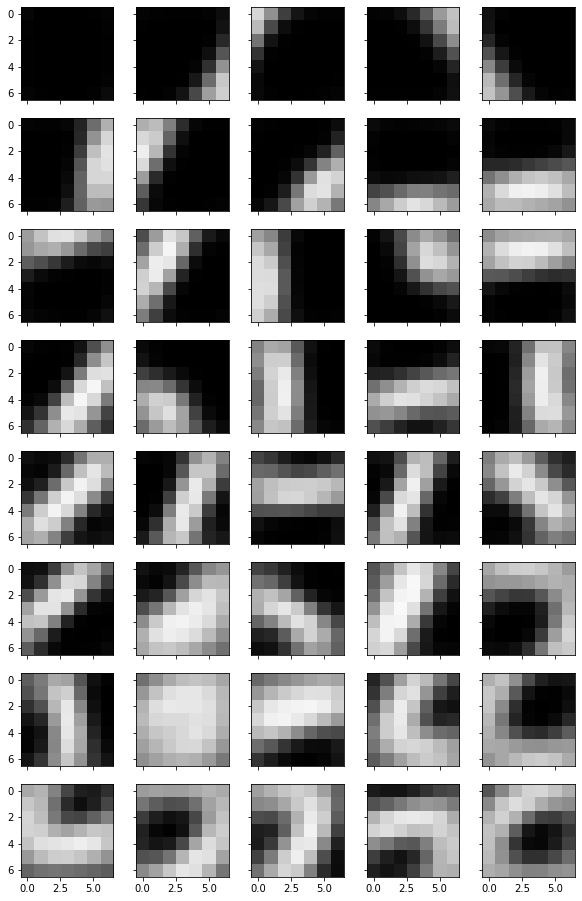

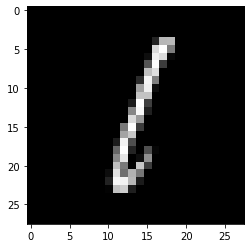

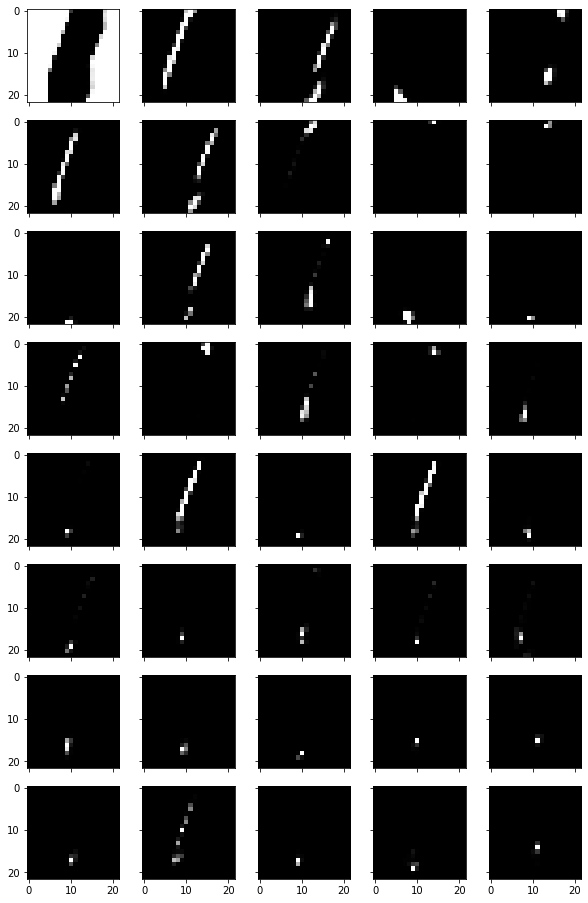

#############################################
Kernel Size: (14,14)
tensor([0.0438, 0.0403, 0.0386, 0.0379, 0.0364, 0.0346, 0.0326, 0.0322, 0.0321,
        0.0278, 0.0267, 0.0266, 0.0262, 0.0252, 0.0252, 0.0251, 0.0246, 0.0245,
        0.0243, 0.0231, 0.0231, 0.0229, 0.0222, 0.0216, 0.0214, 0.0210, 0.0208,
        0.0207, 0.0207, 0.0201, 0.0199, 0.0194, 0.0193, 0.0190, 0.0187, 0.0176,
        0.0166, 0.0163, 0.0162, 0.0148], device='cuda:7')


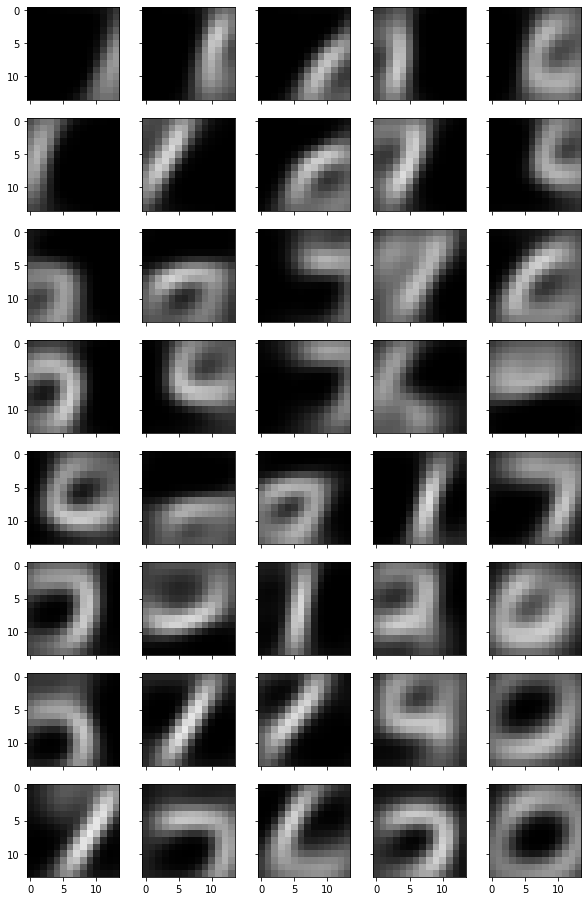

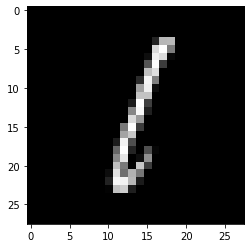

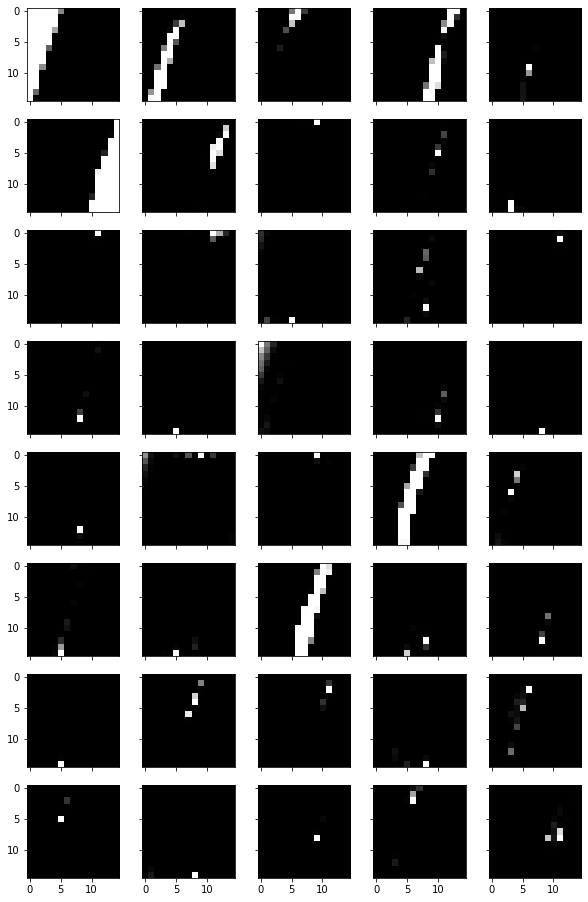

#############################################
Kernel Size: (20,20)
tensor([0.0392, 0.0361, 0.0352, 0.0344, 0.0337, 0.0337, 0.0333, 0.0330, 0.0305,
        0.0296, 0.0293, 0.0282, 0.0277, 0.0272, 0.0265, 0.0265, 0.0265, 0.0261,
        0.0261, 0.0256, 0.0255, 0.0254, 0.0250, 0.0235, 0.0233, 0.0231, 0.0226,
        0.0208, 0.0203, 0.0200, 0.0188, 0.0181, 0.0178, 0.0169, 0.0165, 0.0161,
        0.0156, 0.0146, 0.0141, 0.0136], device='cuda:7')


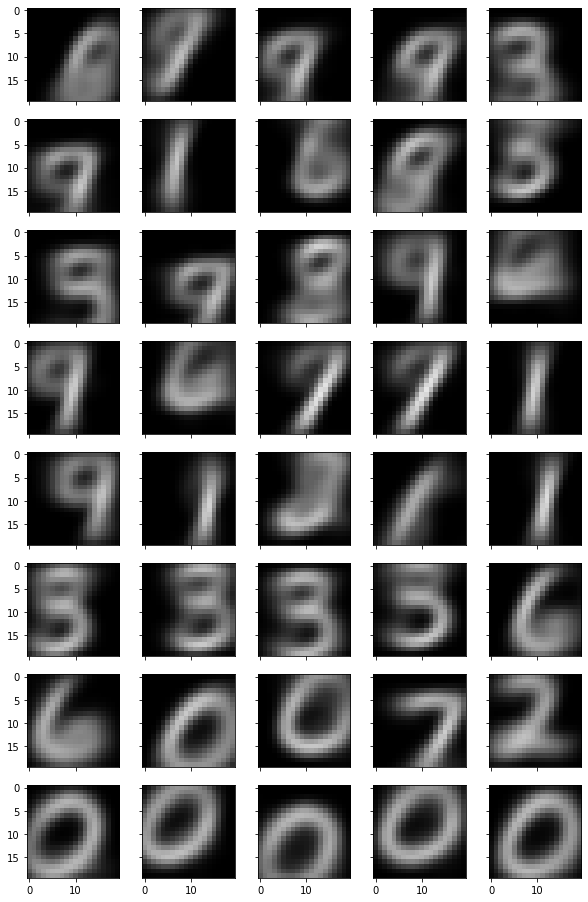

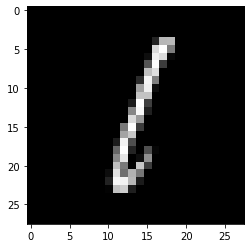

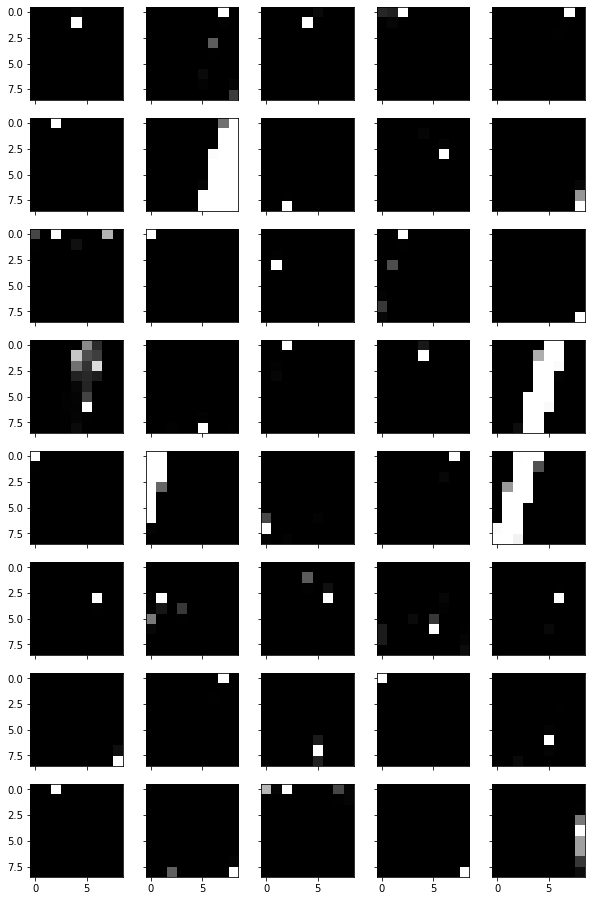

#############################################
Kernel Size: (28,28)
tensor([0.0598, 0.0469, 0.0353, 0.0336, 0.0314, 0.0310, 0.0309, 0.0307, 0.0297,
        0.0286, 0.0280, 0.0277, 0.0275, 0.0271, 0.0270, 0.0266, 0.0259, 0.0256,
        0.0250, 0.0248, 0.0246, 0.0244, 0.0243, 0.0236, 0.0233, 0.0227, 0.0218,
        0.0207, 0.0203, 0.0195, 0.0193, 0.0187, 0.0179, 0.0155, 0.0154, 0.0146,
        0.0134, 0.0133, 0.0129, 0.0112], device='cuda:7')


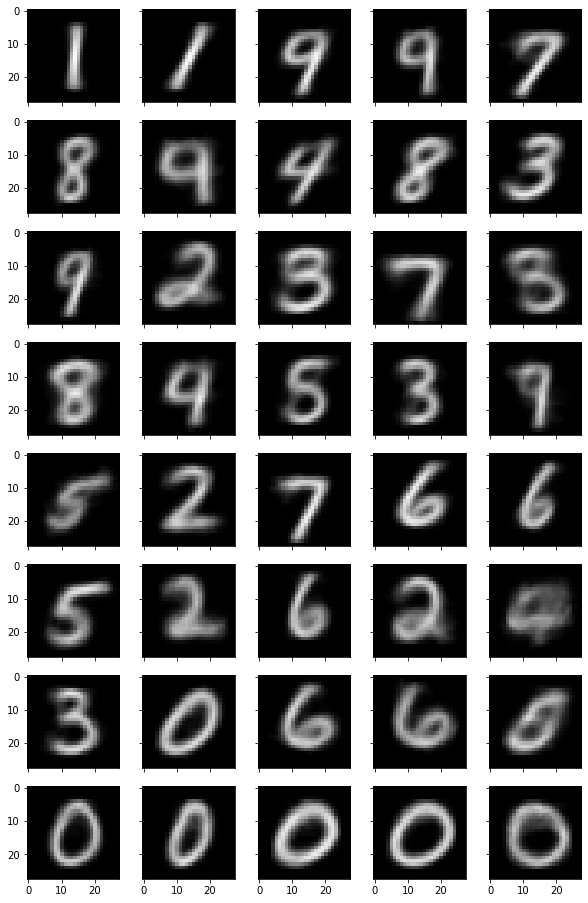

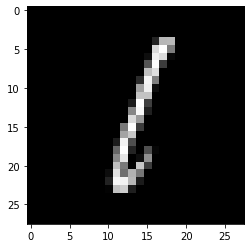

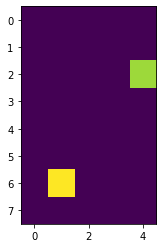

In [13]:
# Experimenting with the kernel window sizes

M = 40
D = 784
epochs = 1
eta = 0.95
kernels = [2,3,4,5,6,7,14,20,28]
(dodata, _) = next(iter(train))
dodata = dodata.to(device)

for k in kernels:
    print ("#############################################")
    print ("Kernel Size: ({},{})".format(k,k))
    kernel = (k,k)
    cmodel = CEMMB((1,28,28), M, kernel, eta=eta).to(device)

    for e in range(epochs):
        for (data, label) in train:
            data = data.to(device)
            cmodel.learn(data)

    (pi, mu) = cmodel.params()
    plotMeans(pi, mu, shape=kernel)
    plotActivation(dodata, cmodel)

tensor([0.0458, 0.0363, 0.0328, 0.0303, 0.0300, 0.0294, 0.0293, 0.0293, 0.0291,
        0.0275, 0.0274, 0.0269, 0.0269, 0.0268, 0.0264, 0.0257, 0.0256, 0.0254,
        0.0253, 0.0247, 0.0246, 0.0245, 0.0244, 0.0236, 0.0231, 0.0223, 0.0221,
        0.0218, 0.0217, 0.0217, 0.0216, 0.0204, 0.0203, 0.0201, 0.0198, 0.0194,
        0.0193, 0.0188, 0.0162, 0.0132], device='cuda:7')


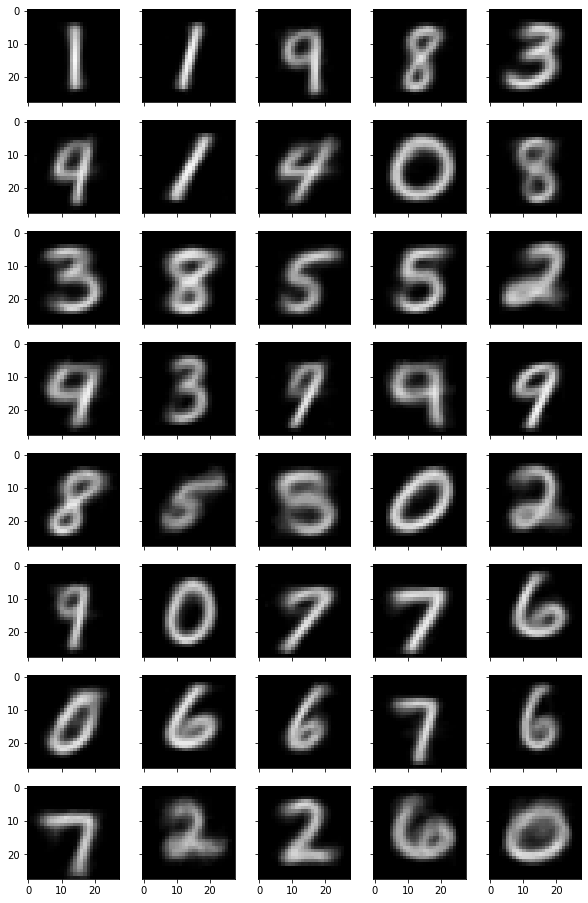

In [44]:
# Ok lets use the fullest model and just see how good of a classifier it is on its own
M = 40
D = 784
epochs = 1
eta = 0.95

kernel = (28,28)
cmodel = CEMMB((1,28,28), M, kernel, eta=eta).to(device)

for e in range(epochs):
    for (data, label) in train:
        data = data.to(device)
        cmodel.learn(data)

(pi, mu) = cmodel.params()
plotMeans(pi, mu, shape=kernel)

(trainacc, labels, result) = evalModel(train, 10, cmodel, device=device, soft=True)
(testacc, _, _) = evalModel(test, 10, cmodel, labels=labels, device=device, soft=True)

print ('Train Accuracy: {}%'.format(100*trainacc))
print ('Test  Accuracy: {}%'.format(100*testacc))

In [53]:
# Ok lets use the fullest model and just see how good of a classifier it is on its own
Ms = [10,20,40,80,160,320,640]

epochs = 1
eta = 0.95
trs = []
tes = []

kernel = (28,28)
for M in Ms:
    cmodel = CEMMB((1,28,28), M, kernel, eta=eta).to(device)
    for e in range(epochs):
        for (data, label) in train:
            data = data.to(device)
            cmodel.learn(data)

    (tracc, labels, _) = evalModel(train, 10, cmodel, device=device)
    (teacc, _, _) = evalModel(test, 10, cmodel, labels=labels, device=device)
    trs.append(tracc)
    tes.append(teacc)
    print ("Modes: {} Train acc: {:.2f}% Test acc: {:.2f}% ".format(M, tracc*100, teacc*100))

Modes: 10 Train acc: 57.16% Test acc: 58.30% 
Modes: 20 Train acc: 70.49% Test acc: 71.28% 
Modes: 40 Train acc: 77.88% Test acc: 79.25% 
Modes: 80 Train acc: 83.56% Test acc: 84.64% 
Modes: 160 Train acc: 85.86% Test acc: 86.35% 
Modes: 320 Train acc: 86.91% Test acc: 87.43% 
Modes: 640 Train acc: 87.70% Test acc: 87.89% 


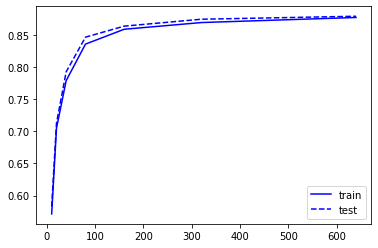

In [54]:
plt.plot(Ms, trs, 'b', label='train')
plt.plot(Ms, tes, '--b', label='test')
plt.legend()
plt.show()

In [7]:
# Ok lets mess around with multi-layer clustering
# This is passed lists of structural parameters and constructs
# multilayer cluster CNN
class MLMM(nn.Module):
    def __init__(self, kernels, Ms, img_shape, eta, device):
        super().__init__()
        
        self.kernels = kernels
        self.Ms = Ms
        self.layers = nn.ModuleList()
        self.M = Ms[-1] # number of modes for final layer
        
        for i in range(len(kernels)):
            self.layers.append(CEMMB(img_shape, Ms[i], kernels[i], eta=eta).to(device))
            img_shape = self.layers[-1].output_shape
    
    def forward(self, data, full=False):
        Ys = [data]
        for l in self.layers:
            Ys.append(l(Ys[-1]))
        if (full):
            return Ys
        else:
            return Ys[-1]
        
    def learn(self, data):
        Ys = self.forward(data, full=True)
        for i in range(len(self.layers)):
            self.layers[i].learn(Ys[i])
            
    def params(self):
        return [l.params() for l in self.layers]

    
    
# This is a test running script, it takes the train, test datasets and 
# a list of test model parameters. It will do some evaluation on the final 
# layers before and after train and run the training algorithm.
# NOTE: the learning algorithm is implemented in the model class itself
# hence we call model.learn()

# Function returns the models (after transferring to cpu) and the test results
def runMLTests(tests, train, test, epochs=1, eta=0.95, device='cpu', verbose=False):
    testresults = []
    models = []
    for t in tests:
        print ("Running Test: {}".format(t))
        with silence(not verbose):
            kernels, Ms = t
            img_shape = (1,28,28)

            cmodel = MLMM(kernels, Ms, img_shape, eta, device)

            print ("Evaluating untrained model...")
            (tracc, labels, _) = evalModel(train, 10, cmodel, device=device)
            (teacc, _, _) = evalModel(test, 10, cmodel, labels=labels, device=device)
            print ("Train acc: {:.2f}% Test acc: {:.2f}% ".format(tracc*100, teacc*100))
            pre = (tracc, teacc)

            print ("Training...")
            for e in range(epochs):
                for (data, label) in train:
                    data = data.to(device)
                    cmodel.learn(data)

            # (pi, mu) = cmodel.params()
            # plotMeans(pi, mu, shape=kernel)

            print ("Evaluating trained model...")

            (tracc, labels, _) = evalModel(train, 10, cmodel, device=device)
            (teacc, _, _) = evalModel(test, 10, cmodel, labels=labels, device=device)
            print ("Train acc: {:.2f}% Test acc: {:.2f}% ".format(tracc*100, teacc*100))
            post = (tracc, teacc)
            testresults.append((pre, post))
            cmodel = cmodel.cpu()
            models.append(cmodel)
            print ("-----------------------------------------\n")
        
    return testresults, models
        
epochs = 1
eta = 0.95        

tests = [([(28,28)], [80])]
# ,
#          ([(28,28),(1,1)], [80,10]),
#          ([(28,28),(1,1)], [80,40]),
#          ([(28,28),(1,1),(1,1),(1,1)], [80,40,40,40]),
#          ([(28,28)], [400]),
#          ([(7,7),(22,22)], [10, 400]),
#          ([(7,7),(7,7),(16,16)], [10, 40, 400]),
#          ([(7,7),(7,7),(7,7),(10,10)], [10, 40, 40, 400]),
#          ([(7,7),(7,7),(7,7),(7,7),(4,4)], [10, 40, 40, 40, 400])]

testresults, models = runMLTests(tests, train, test, epochs=epochs, eta=eta, device=device)
pptestresults(tests, testresults)

Running Test: ([(28, 28)], [80])
layers: 1 | 22.08/22.32 -> 82.82/83.57 | ([(28, 28)], [80])


In [56]:
pptestresults(tests, testresults)

layers: 1 | 20.24/20.63 -> 83.14/83.82 | ([(28, 28)], [80])


In [ ]:
pptestresults(tests, testresults)

In [8]:

# Flattens activations into a single sheet.
# if pool is True it will use maximum activation over the spatial dimensions
def fullstack(Ys, pool=False):
    (bs,c,h,w) = Ys[0].shape
    if pool:
        tYs = [torch.max(Y.view(Y.shape[0],Y.shape[1],-1), dim=-1)[0] for Y in Ys]
    else:
        tYs = [Y.view(bs, -1) for Y in Ys]
    return torch.cat(tYs, dim=1)


# Calculates the node activation map for all layers of activation in a deep network
# result can be viewed as a probabilistic map. (P(label|node =(active/not)))
# The returned map will be used to find what nodes have a large amount of information gain
def MEGAfreqMap(dataset, classes, model, device='cpu', norm=True, pool=False):
    (data, label) = next(iter(dataset))
    data = data.to(device)
    model = model.to(device)
    Ys = model(data, full=True)
    fY = fullstack(Ys, pool=pool)
    fl = fY.shape[1]
    print (fl)
    result = torch.zeros((classes, 2, fl))
    N = 0
#     return
    for (data, label) in dataset:
        data = data.to(device)
        Ys = model(data, full=True)
        fY = fullstack(Ys, pool=pool).cpu()
        for i in range(fY.shape[0]):
            result[label[i], 1] += fY[i]
            result[label[i], 0] += (1-fY[i])
            N += 1
    if (norm):
        return result/(N+1e-20)
    return result

# result = MEGAfreqMap(train, 10, models[0], device=device)
# result = MEGAfreqMap(test, 10, models[0], device=device)
# print (result.shape)
result = MEGAfreqMap(test, 10, models[0], device=device, pool=True)
print (result.shape)

81
torch.Size([10, 2, 81])


In [9]:
# This cell contains information calculation functions, each one takes in a probability
# matrix and returns a number

def nodewiseMI(pxy):
    N = pxy.shape[0]
    px = torch.sum(pxy, dim=0, keepdim=True)
    py = torch.sum(pxy, dim=1, keepdim=True)
    
    mask = 1-torch.isclose(pxy/(px*py+1e-40), torch.tensor(1.0)).float()
    
    form = pxy*torch.log2(pxy/(px*py+1e-40)+1e-40)*mask
    
    MI = torch.sum(form, dim=[0,1])
    
    return MI

def nodewiseE(py):
    N = py.shape[0]
    # Ensure Probability Distribution
    py = py/(py.sum(dim=0, keepdim=True)+1e-40)
    mask = 1-torch.isclose(py, torch.tensor(1.0)).float()
    form = py*torch.log2(py+1e-40)*mask
    E = -torch.sum(form, dim=0)
    return E

def nodewiseIG(pxy, x=1):
    HY = nodewiseE(pxy.sum(dim=1))
    HYGX = nodewiseE(pxy[:,x])
    return HY - HYGX



# pxy = MEGAfreqMap(test, 10, dummy())
# px = torch.ones((1,2))*0.5
# py = torch.ones((10,1))*0.1
# pxy = px*py
pxy = torch.zeros((10,2))
pxy[:5,0] = 0.1
pxy[:,1] = 0.05
print (pxy[:,0])
print (pxy.shape)
MI = nodewiseMI(pxy)
# MI = nodewiseCE(pxy)
# print (MI)
print (MI.max().item())
# plt.plot(MI)
# plt.show()

# plt.imshow(MI.view(28,28), cmap='gray')
# plt.show()
py = torch.ones(10,1)/10
HY = nodewiseE(py)
print (HY)
IG0 = nodewiseIG(pxy, x=0)
IG1 = nodewiseIG(pxy, x=1)
print (IG0)
print (IG1)
print (0.5*IG0 + 0.5*IG1)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
torch.Size([10, 2])
0.31127798557281494
tensor([3.3219])
tensor(0.8113)
tensor(-0.1887)
tensor(0.3113)


784
tensor([[0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
        [0.1135, 0.1135, 0.1135,  ..., 0.1135, 0.1135, 0.1135],
        [0.1032, 0.1032, 0.1032,  ..., 0.1032, 0.1032, 0.1032],
        ...,
        [0.1028, 0.1028, 0.1028,  ..., 0.1028, 0.1028, 0.1028],
        [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
        [0.1009, 0.1009, 0.1009,  ..., 0.1009, 0.1009, 0.1009]])
0.2911413908004761


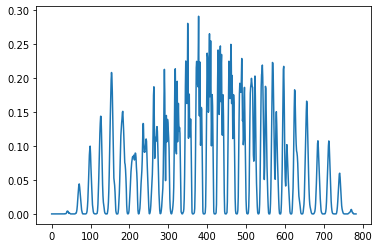

In [60]:
# This is an experimental cell that shows the mutual information of a raw image for
# each location in the image.

class dummy(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, full=False):
        if (full):
            return [x]
        return x

m = dummy()

pxy = MEGAfreqMap(test, 10, m)
print (pxy[:,0])
MI = nodewiseMI(pxy)
# MI = nodewiseCE(pxy)
print (MI.max().item())
plt.plot(MI)
plt.show()

In [10]:
# These are helpful functions for generating the information gain results
# Analyze Models will take the tests, models and a dataset and will produce plots

def chunkysort(data, breaks):
    newdata = torch.zeros_like(data)
    o = 0
    for b in breaks:
        newdata[o:b] = torch.sort(data[o:b])[0]
        o = b
    return newdata

def layerends(model, pool=False):

    if (pool):
        ends = [1]
        for l in model.layers:
            ends.append(ends[-1] + l.F)
    else:
    #     ends = [np.prod(model.layers[0].input_size)]        
        ends = [784]
        for l in model.layers:
            ends.append(ends[-1]+np.prod(l.output_shape))
    return ends

# THe options for this:
# pool=True: This means that the maximum of the activation of a mode over the input will be
# used. This deletes remaining spatial information. Useful because knowing a feature is
# on at a specific location is often very informative but brittle. (artifact of the dataset)
# IG=True uses information gain metric rather than mutual information
# maxgain, just a number to put the horizontal line in the plots on. is None won't plot.
# sort=True: sorts all the nodes in the plot within their layers so the image is clearer
# doreturn will return the information at the end, (incase you want to inspect further)
def analyzeModels(tests, models, dataset, pool=True, IG=True, maxgain=None, figsize=(10,4), sort=True, doreturn=False):
    Is = []
    for i, model in enumerate(models):
        print ("\nTest: {}".format(tests[i]))
        ends = layerends(model, pool=pool)
        pxy = MEGAfreqMap(dataset, 10, model, device=device, pool=pool)
        
        if (IG):
            I = nodewiseIG(pxy, x=1)
        else:
            I = nodewiseMI(pxy)
        
        fig = plt.figure(figsize=figsize)
        
        if (maxgain is not None):
            plt.axhline(maxgain, c='g', ls='-.')
            
        if (sort):
            Is.append(chunkysort(I, ends))
            plt.plot(chunkysort(I, ends))
        else:
            Is.append(I)
            plt.plot(I)
        
        for end in ends:
            plt.axvline(end, c='r', ls='--')
        
        plt.show()
    
    if doreturn:
        return Is
    #     break

# maxgain = -np.log2(0.1)
# analyzeModels(tests,models, pool=True, maxgain=maxgain)
# analyzeModels(models, pool=False, sort=False)


# The Meat Section

All of the above is more or less setting up all the bits needed to actually do some experimentation. Its important but I'm going to try to contain the investigative elements to this next section. Eventually the above will become super clean, just code but I don't trust it yet.

What experiments will we do?

1. Effect of going deep -> Test 2-4 
2. Effect of training on the information gain metric -> Test 5   
3. Parameter tuning (construct a network that has best kernel sizes and #modes)    
4. Investigate other aspects such as:    
    a. Reconstruction of higher level means via gradient ascent    
    b. Measuring the amount of "unexplained signal" throughout the layers    
    c. Try to see if there is some unifying rule for how to choose parameters    
5. Try the association areas, (feed in the label at a particular level)    
6. Attempt feedback    
7. Attempt to incorporate temporal clustering (Probably another notebook)

### Questions
Why does the final layer always seem to have the most nodes with high correlation?
Can we induce the second final layer to have higher correlation?

Can I find any correlation? If I perform a random labelling will the correlation tank? Basically, can I find a labelling to get any connections I want out of this?

Focus on the predictive power of the deeper networks on its input space.

Running Test: ([(28, 28)], [10])
Running Test: ([(28, 28)], [20])
Running Test: ([(28, 28)], [40])
Running Test: ([(28, 28)], [80])
Running Test: ([(28, 28)], [160])
Running Test: ([(28, 28)], [320])
Running Test: ([(28, 28)], [640])
layers: 1 | 23.41/23.80 -> 58.95/59.20 | ([(28, 28)], [10])
layers: 1 | 20.60/21.35 -> 71.34/72.45 | ([(28, 28)], [20])
layers: 1 | 23.20/23.05 -> 78.23/79.07 | ([(28, 28)], [40])
layers: 1 | 26.41/27.26 -> 83.23/84.32 | ([(28, 28)], [80])
layers: 1 | 25.46/25.67 -> 85.53/86.55 | ([(28, 28)], [160])
layers: 1 | 24.43/24.78 -> 85.94/86.30 | ([(28, 28)], [320])
layers: 1 | 24.05/24.47 -> 86.91/87.42 | ([(28, 28)], [640])

Test: ([(28, 28)], [10])
11


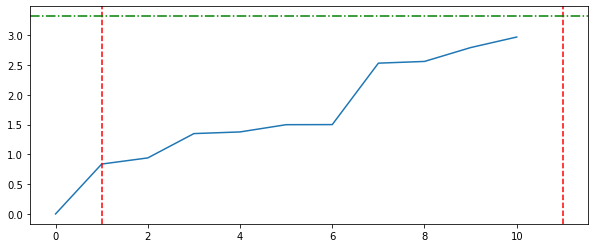


Test: ([(28, 28)], [20])
21


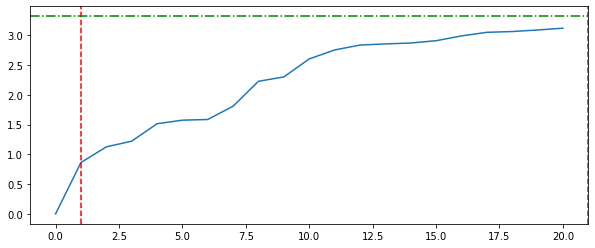


Test: ([(28, 28)], [40])
41


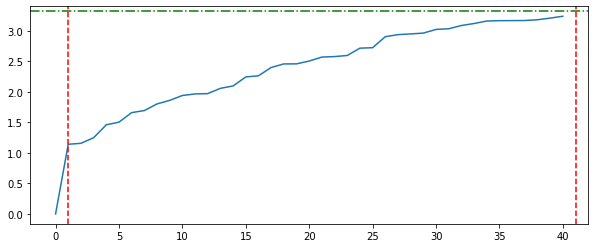


Test: ([(28, 28)], [80])
81


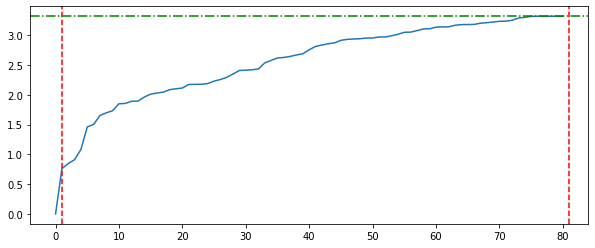


Test: ([(28, 28)], [160])
161


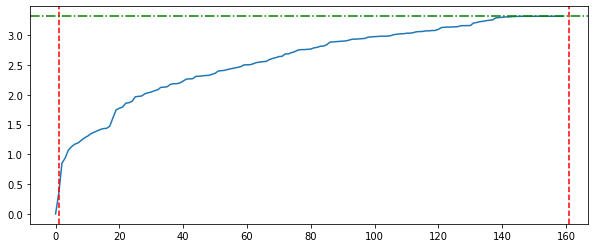


Test: ([(28, 28)], [320])
321


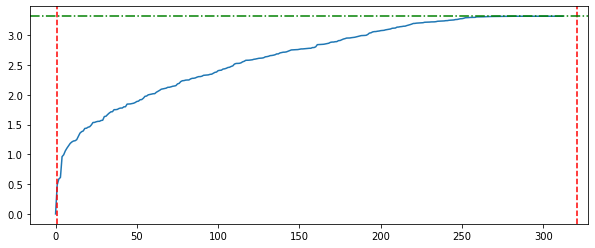


Test: ([(28, 28)], [640])
641


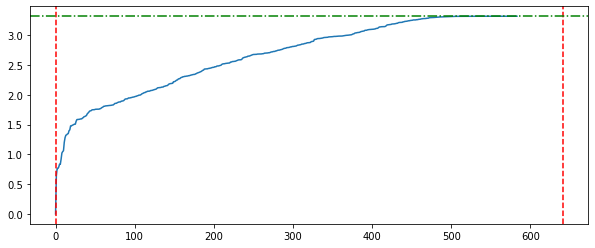

In [13]:
# Test 1) effect of number of modes on single layer network

epochs = 2
eta = 0.95        

tests = [([(28,28)], [10]),
          ([(28,28)], [20]),
          ([(28,28)], [40]),
          ([(28,28)], [80]),
          ([(28,28)], [160]),
          ([(28,28)], [320]),
          ([(28,28)], [640])]

testresults, models = runMLTests(tests, train, test, epochs=epochs, eta=eta, device=device)


pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test, pool=True, maxgain=maxgain)

Running Test: ([(28, 28)], [80])
Running Test: ([(28, 28), (1, 1)], [80, 40])
Running Test: ([(28, 28), (1, 1), (1, 1), (1, 1)], [80, 40, 40, 40])
layers: 1 | 28.04/29.58 -> 83.40/84.13 | ([(28, 28)], [80])
layers: 2 | 12.20/12.04 -> 17.88/17.96 | ([(28, 28), (1, 1)], [80, 40])
layers: 4 | 11.24/11.35 -> 11.24/11.35 | ([(28, 28), (1, 1), (1, 1), (1, 1)], [80, 40, 40, 40])

Test: ([(28, 28)], [80])
81


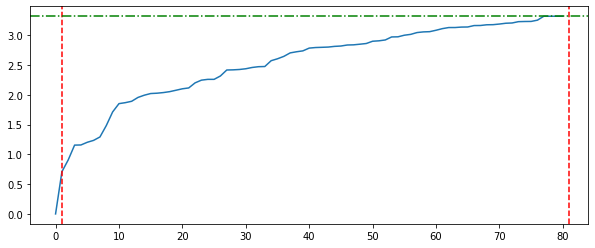


Test: ([(28, 28), (1, 1)], [80, 40])
121


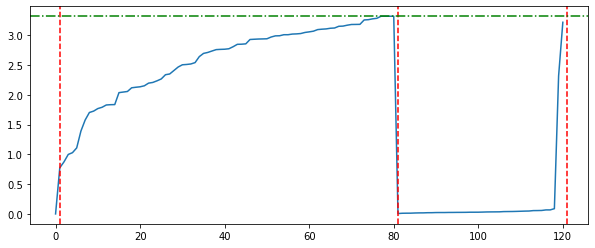


Test: ([(28, 28), (1, 1), (1, 1), (1, 1)], [80, 40, 40, 40])
201


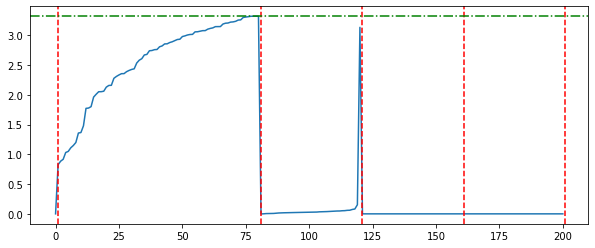

In [77]:
# Test 2) What happens if additional layers are added after the first complete one?

epochs = 2
eta = 0.95        

tests = [([(28,28)], [80]),
          ([(28,28),(1,1)], [80,40]),
          ([(28,28),(1,1),(1,1),(1,1)], [80,40,40,40])]

testresults, models = runMLTests(T2tests, train, test, epochs=epochs, eta=eta, device=device)
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test, pool=True, maxgain=maxgain)

Running Test: ([(28, 28)], [400])
Running Test: ([(7, 7), (22, 22)], [10, 400])
Running Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [10, 40, 40, 400])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [10, 40, 40, 40, 400])
layers: 1 | 16.24/16.39 -> 86.50/87.14 | ([(28, 28)], [400])
layers: 2 | 20.56/20.48 -> 83.84/85.32 | ([(7, 7), (22, 22)], [10, 400])
layers: 3 | 14.90/15.20 -> 83.76/83.76 | ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
layers: 4 | 12.53/12.74 -> 78.18/78.85 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [10, 40, 40, 400])
layers: 5 | 11.24/11.35 -> 68.41/69.25 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [10, 40, 40, 40, 400])

Test: ([(28, 28)], [400])
401


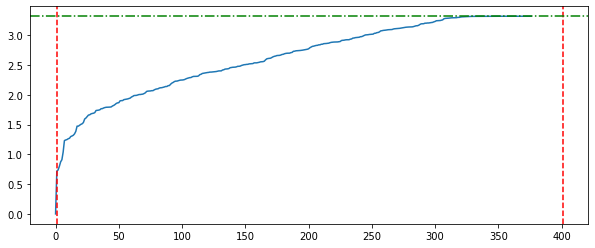


Test: ([(7, 7), (22, 22)], [10, 400])
411


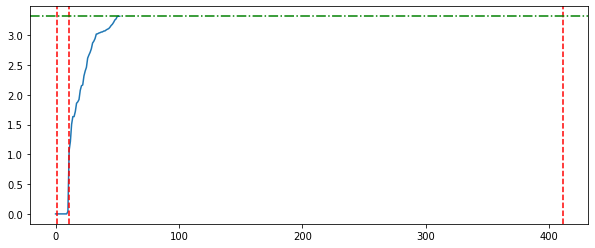


Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
451


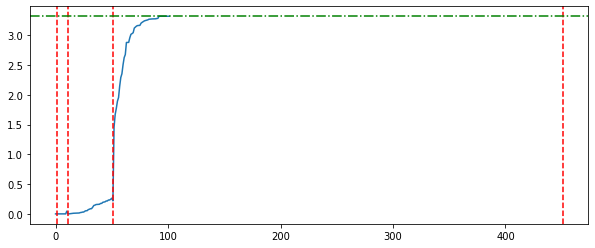


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [10, 40, 40, 400])
491


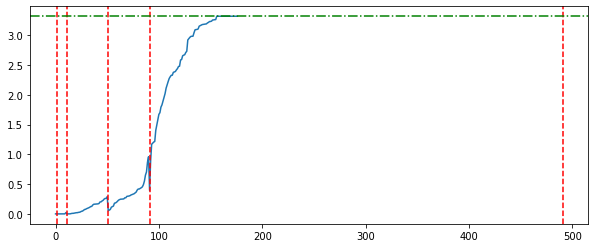


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [10, 40, 40, 40, 400])
531


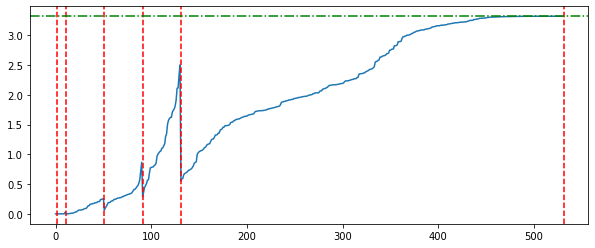

In [80]:
# Test 3) Going deep (can we find evidence that deeper is better)

epochs = 2
eta = 0.95        

tests = [([(28,28)], [400]),
          ([(7,7),(22,22)], [10, 400]),
          ([(7,7),(7,7),(16,16)], [10, 40, 400]),
          ([(7,7),(7,7),(7,7),(10,10)], [10, 40, 40, 400]),
          ([(7,7),(7,7),(7,7),(7,7),(4,4)], [10, 40, 40, 40, 400])]

testresults, models = runMLTests(tests, train, test, epochs=epochs, eta=eta, device=device)
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test, pool=True, maxgain=maxgain)

Running Test: ([(28, 28)], [100])
Running Test: ([(7, 7), (22, 22)], [40, 100])
Running Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 1 | 30.50/30.75 -> 72.14/72.79 | ([(28, 28)], [100])
layers: 2 | 11.45/11.60 -> 62.51/63.32 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 14.04/14.15 -> 53.69/55.03 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 4 | 11.24/11.35 -> 60.61/62.37 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 57.60/57.62 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(28, 28)], [100])
101


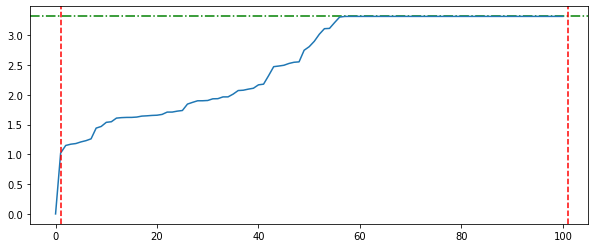


Test: ([(7, 7), (22, 22)], [40, 100])
141


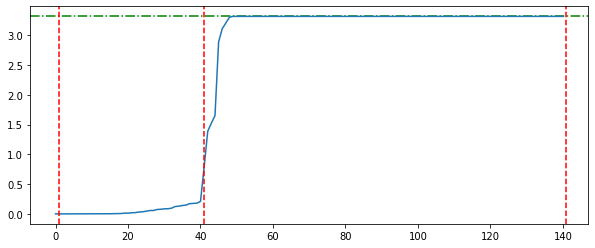


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


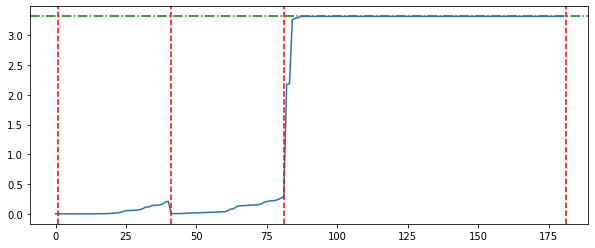


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


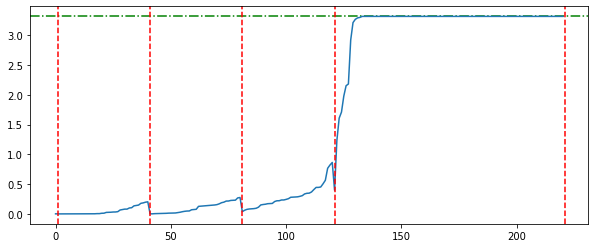


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


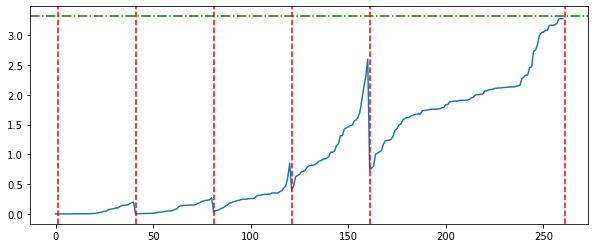

In [46]:
# Test 4) Going deep (can we find evidence that deeper is better) AVOID bottleneck layer

epochs = 1
eta = 0.95        

tests = [([(28,28)], [100]),
          ([(7,7),(22,22)], [40, 100]),
          ([(7,7),(7,7),(16,16)], [40, 40, 100]),
          ([(7,7),(7,7),(7,7),(10,10)], [40, 40, 40, 100]),
          ([(7,7),(7,7),(7,7),(7,7),(4,4)], [40, 40, 40, 40, 100])]

testresults, models = runMLTests(tests, train20, test20, epochs=epochs, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

Running Test: ([(28, 28)], [400])
Running Test: ([(7, 7), (22, 22)], [10, 400])
Running Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
layers: 1 | 29.77/29.31 -> 29.77/29.31 | ([(28, 28)], [400])
layers: 2 | 20.09/19.95 -> 20.09/19.95 | ([(7, 7), (22, 22)], [10, 400])
layers: 3 | 20.08/20.34 -> 20.08/20.34 | ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])

Test: ([(28, 28)], [400])
401


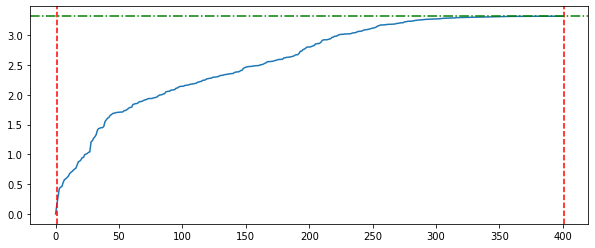


Test: ([(7, 7), (22, 22)], [10, 400])
411


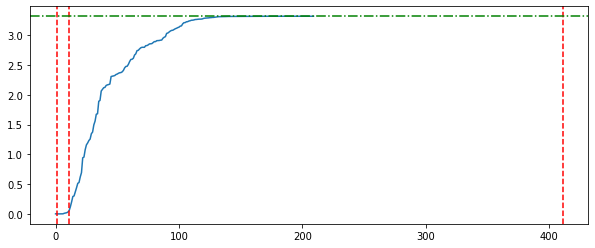


Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
451


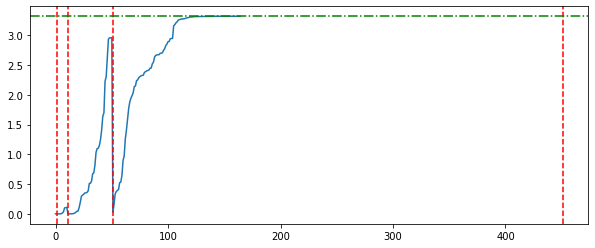

Running Test: ([(28, 28)], [400])
Running Test: ([(7, 7), (22, 22)], [10, 400])
Running Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
layers: 1 | 28.13/30.00 -> 86.44/86.50 | ([(28, 28)], [400])
layers: 2 | 19.54/18.99 -> 76.61/77.46 | ([(7, 7), (22, 22)], [10, 400])
layers: 3 | 11.24/11.35 -> 87.25/87.03 | ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])

Test: ([(28, 28)], [400])
401


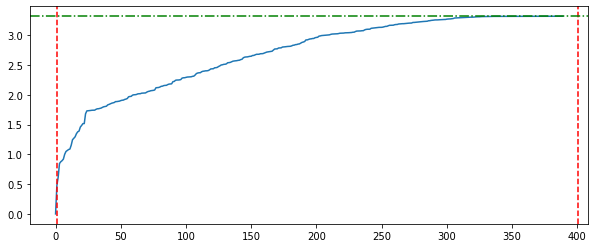


Test: ([(7, 7), (22, 22)], [10, 400])
411


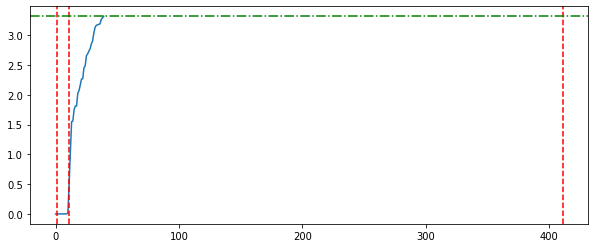


Test: ([(7, 7), (7, 7), (16, 16)], [10, 40, 400])
451


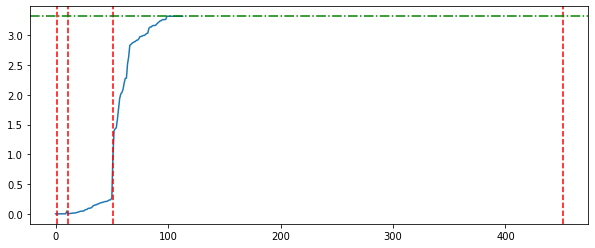

In [20]:
# Test number 5 - How does training affect the network?

epochs = 2
eta = 0.95        

tests = [([(28,28)], [400]),
          ([(7,7),(22,22)], [10, 400]),
          ([(7,7),(7,7),(16,16)], [10, 40, 400])]

testresults, models = runMLTests(tests, train, test, epochs=0, eta=eta, device=device)
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, pool=True, maxgain=maxgain)

testresults, models = runMLTests(tests, train, test, epochs=epochs, eta=eta, device=device)
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, pool=True, maxgain=maxgain)

layers: 2 | 12.35/12.55 -> 62.12/62.86 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 18.38/17.57 -> 42.43/42.07 | ([(7, 7), (1, 1), (22, 22)], [40, 10, 100])
layers: 3 | 16.50/16.43 -> 52.43/53.34 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 5 | 11.24/11.35 -> 30.17/30.09 | ([(7, 7), (1, 1), (7, 7), (1, 1), (16, 16)], [40, 10, 40, 10, 100])
layers: 4 | 11.24/11.35 -> 58.67/58.70 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 7 | 11.24/11.35 -> 39.97/41.07 | ([(7, 7), (1, 1), (7, 7), (1, 1), (7, 7), (1, 1), (10, 10)], [40, 10, 40, 10, 40, 10, 100])

Test: ([(7, 7), (22, 22)], [40, 100])
141


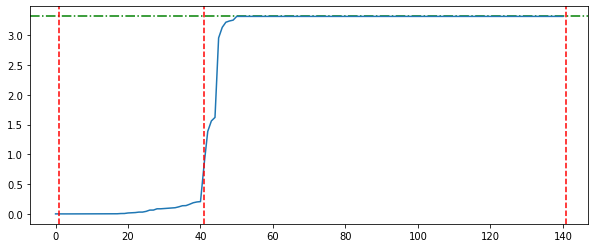


Test: ([(7, 7), (1, 1), (22, 22)], [40, 10, 100])
151


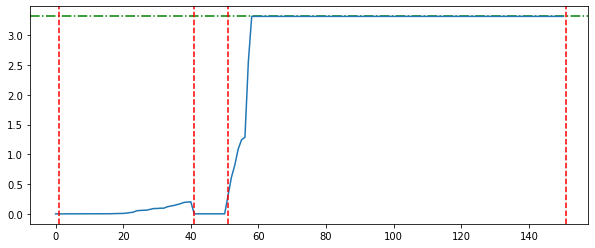


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


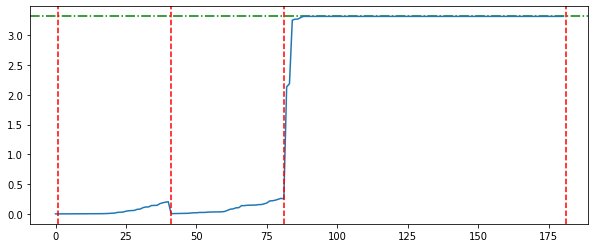


Test: ([(7, 7), (1, 1), (7, 7), (1, 1), (16, 16)], [40, 10, 40, 10, 100])
201


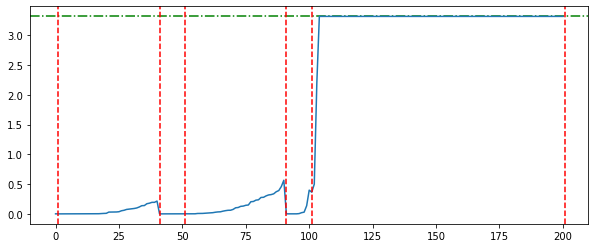


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


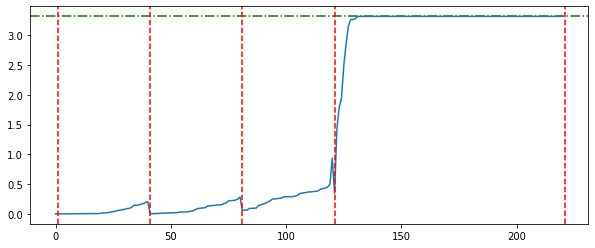


Test: ([(7, 7), (1, 1), (7, 7), (1, 1), (7, 7), (1, 1), (10, 10)], [40, 10, 40, 10, 40, 10, 100])
251


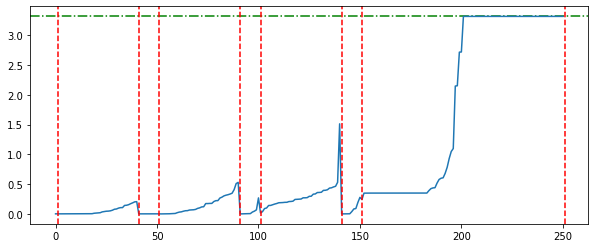

In [48]:
# Test 6 - Do intervening 1x1 clusters degrade the ability to learn?

epochs = 1
eta = 0.95        

tests = [([(7,7),(22,22)], [40, 100]),
         ([(7,7),(1,1),(22,22)], [40, 10, 100]),
         ([(7,7),(7,7),(16,16)], [40, 40, 100]),
         ([(7,7),(1,1),(7,7),(1,1),(16,16)], [40, 10, 40, 10, 100]),
         ([(7,7),(7,7),(7,7),(10,10)], [40, 40, 40, 100]),
         ([(7,7),(1,1),(7,7),(1,1),(7,7),(1,1),(10,10)], [40, 10, 40, 10, 40, 10, 100])]

testresults, models = runMLTests(tests, train20, test20, epochs=epochs, eta=eta, device='cuda:3')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

Running Test: ([(5, 5), (24, 24)], [20, 100])
Running Test: ([(5, 5), (7, 7), (18, 18)], [20, 40, 100])
Running Test: ([(5, 5), (7, 7), (7, 7), (12, 12)], [20, 40, 40, 100])
Running Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 40])
Running Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 100])
Running Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 100, 40])
Running Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 100, 100])
layers: 2 | 24.20/23.69 -> 58.66/58.98 | ([(5, 5), (24, 24)], [20, 100])
layers: 3 | 17.08/16.96 -> 52.62/53.81 | ([(5, 5), (7, 7), (18, 18)], [20, 40, 100])
layers: 4 | 12.45/12.45 -> 54.70/55.24 | ([(5, 5), (7, 7), (7, 7), (12, 12)], [20, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 60.78/62.16 | ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 40])
layers: 5 | 14.03/14.03 -> 62.06/62.84 | ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 67.15/68.52

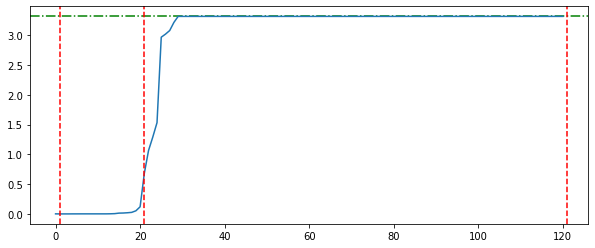


Test: ([(5, 5), (7, 7), (18, 18)], [20, 40, 100])
161


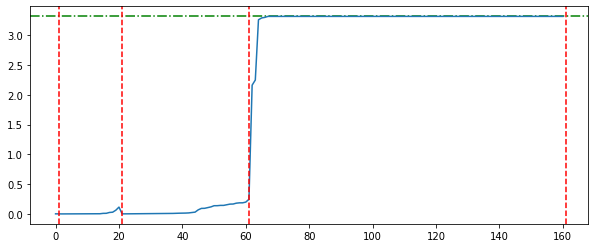


Test: ([(5, 5), (7, 7), (7, 7), (12, 12)], [20, 40, 40, 100])
201


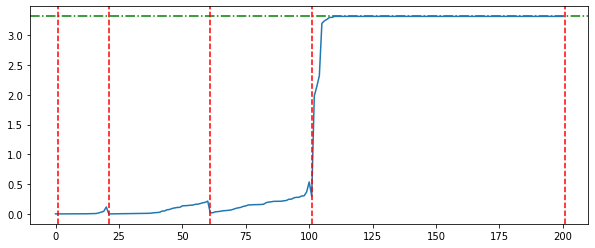


Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 40])
181


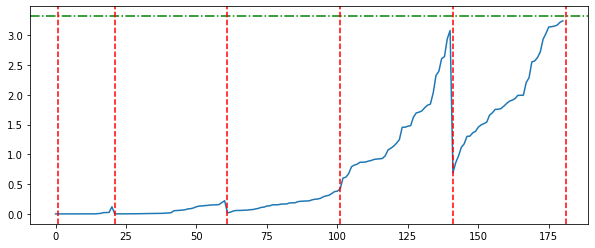


Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 40, 100])
241


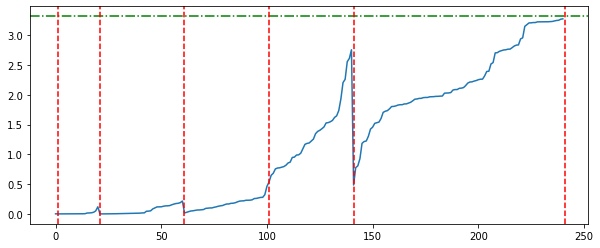


Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 100, 40])
241


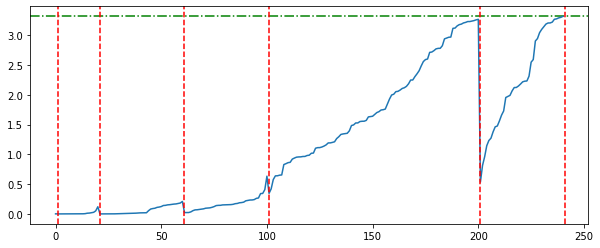


Test: ([(5, 5), (7, 7), (7, 7), (9, 9), (4, 4)], [20, 40, 40, 100, 100])
301


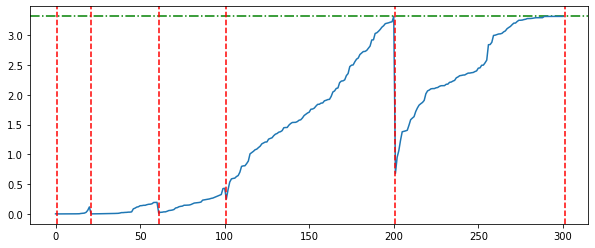

In [11]:
# Test 7 - If properly structured, can we get the second to last layer to have more correlation

epochs = 1
eta = 0.95        

tests = [([(5,5),(24,24)], [20, 100]),
         ([(5,5),(7,7),(18,18)], [20, 40, 100]),
         ([(5,5),(7,7),(7,7),(12,12)], [20, 40, 40, 100]),
         ([(5,5),(7,7),(7,7),(9,9),(4,4)], [20, 40, 40, 40, 40]),
         ([(5,5),(7,7),(7,7),(9,9),(4,4)], [20, 40, 40, 40, 100]),
         ([(5,5),(7,7),(7,7),(9,9),(4,4)], [20, 40, 40, 100, 40]),
         ([(5,5),(7,7),(7,7),(9,9),(4,4)], [20, 40, 40, 100, 100])
        ]

testresults, models = runMLTests(tests, train20, test20, epochs=epochs, eta=eta, device='cuda:3')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 11.24/11.35 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


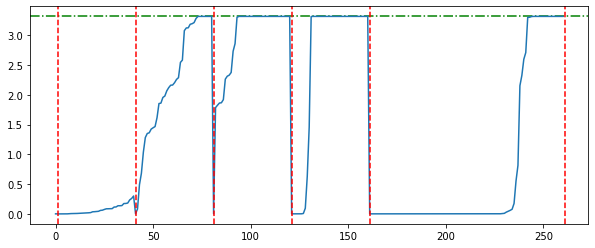

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 57.67/57.52 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


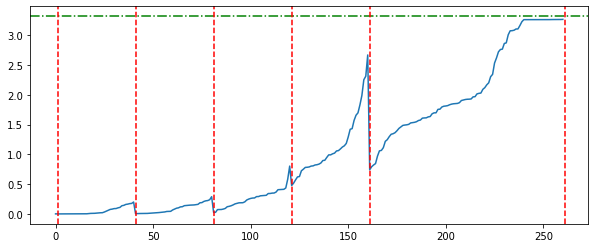

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 55.10/55.36 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


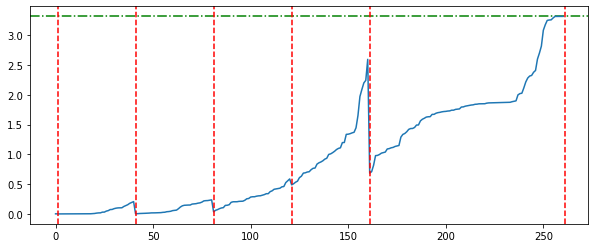

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 12.88/12.90 -> 56.17/56.32 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


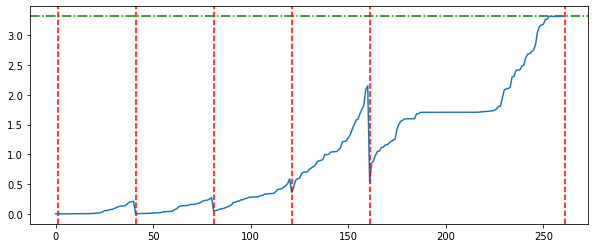

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 54.28/54.65 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


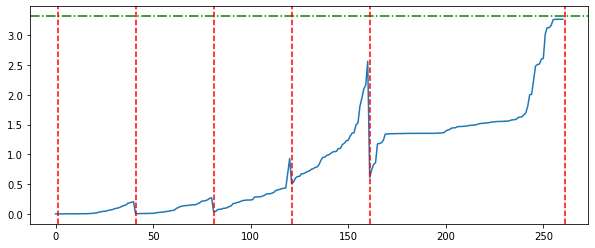

Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 54.57/54.62 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


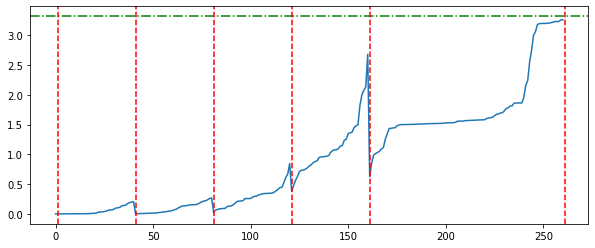

In [12]:
# Test 8 - More training amounts?
# maybe the weird later layers has to do with not receiving enough training

eta = 0.95     

tests = [([(7,7),(7,7),(7,7),(7,7),(4,4)], [40, 40, 40, 40, 100])]

testresults, models = runMLTests(tests, train20, test20, epochs=0, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

tests = [([(7,7),(7,7),(7,7),(7,7),(4,4)], [40, 40, 40, 40, 100])]

testresults, models = runMLTests(tests, train20, test20, epochs=1, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

testresults, models = runMLTests(tests, train20, test20, epochs=2, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

testresults, models = runMLTests(tests, train20, test20, epochs=4, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

testresults, models = runMLTests(tests, train20, test20, epochs=8, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

testresults, models = runMLTests(tests, train20, test20, epochs=16, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)



################## Normal Labels ###################

Running Test: ([(28, 28)], [100])
Running Test: ([(7, 7), (22, 22)], [40, 100])
Running Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 1 | 30.66/31.36 -> 71.05/71.67 | ([(28, 28)], [100])
layers: 2 | 11.48/11.51 -> 62.66/63.51 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 11.24/11.35 -> 54.56/55.68 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 4 | 11.24/11.35 -> 59.97/60.74 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 5 | 11.24/11.35 -> 55.52/56.28 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(28, 28)], [100])
101


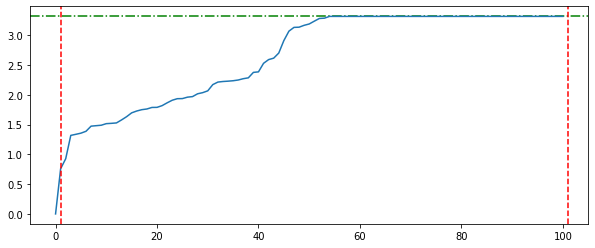


Test: ([(7, 7), (22, 22)], [40, 100])
141


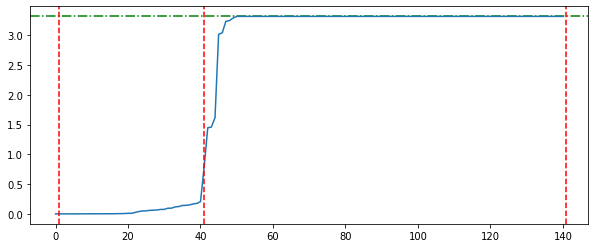


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


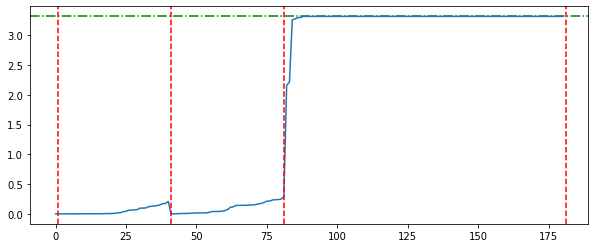


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


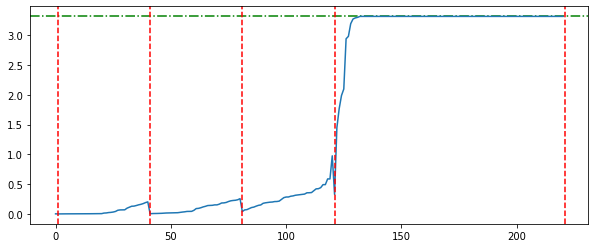


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


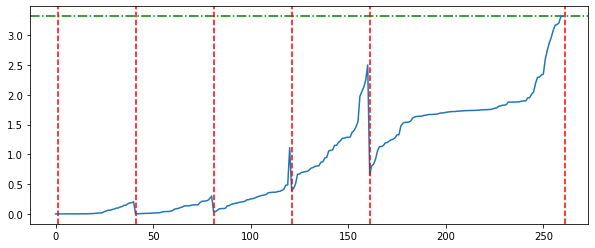



################## Random Labels ###################

Running Test: ([(28, 28)], [100])
Running Test: ([(7, 7), (22, 22)], [40, 100])
Running Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 1 | 10.78/9.85 -> 11.17/10.15 | ([(28, 28)], [100])
layers: 2 | 10.27/10.03 -> 10.64/9.52 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 10.34/9.94 -> 10.48/10.08 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 4 | 10.16/10.15 -> 10.55/9.99 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 5 | 10.15/10.14 -> 11.23/10.02 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(28, 28)], [100])
101


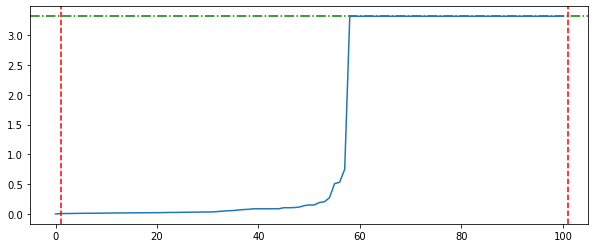


Test: ([(7, 7), (22, 22)], [40, 100])
141


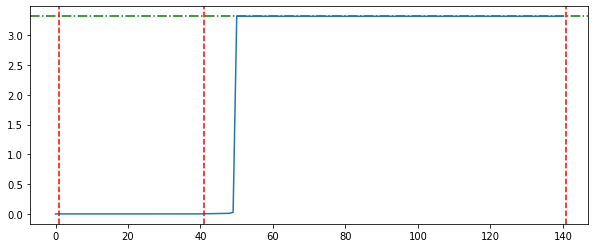


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


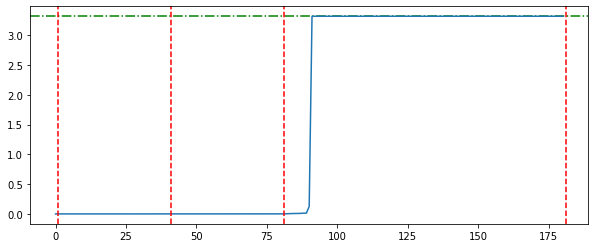


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


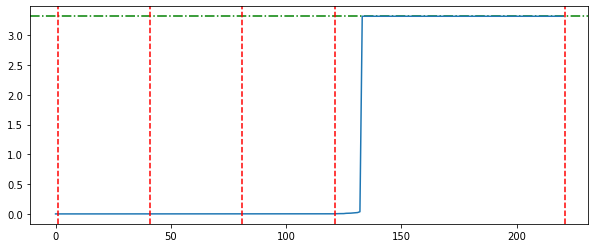


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


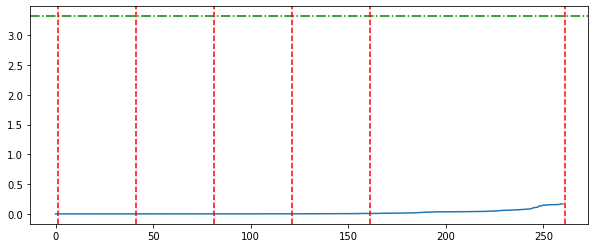

In [19]:
# Test 9 - Random labels
# I want to see if I can still find the kinds of correlations that I'm seeing with actual
# labels if I randomize the label correlations.# Test 4) Going deep (can we find evidence that deeper is better) AVOID bottleneck layer

# from Distributions import MNISTRandomLabels


import torchvision.datasets as datasets


class MNISTRandomLabels(datasets.MNIST):
    """MNIST dataset, with support for randomly corrupt labels.
    Params
    ------
    corrupt_prob: float
      Default 0.0. The probability of a label being replaced with
      random label.
    num_classes: int
      Default 10. The number of classes in the dataset.
    """
    def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = num_classes
        if corrupt_prob > 0:
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.targets)
        np.random.seed(12345)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        # we need to explicitly cast the labels from npy.int64 to
        # builtin int type, otherwise pytorch will fail...
        labels = [int(x) for x in labels]

        if self.train:
            self.targets = labels
        else:
            self.targets = labels

# Smaller batch size datasets (to avoid out of memory issues)
# Training dataset
Rtrain = torch.utils.data.DataLoader(
    MNISTRandomLabels(root='./MNIST', train=True, download=True, corrupt_prob=1.0,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=20, shuffle=True, pin_memory=False)

# Test dataset
Rtest = torch.utils.data.DataLoader(
    MNISTRandomLabels(root='./MNIST', train=False, corrupt_prob=1.0, 
                    transform=transforms.Compose([
                        transforms.ToTensor()
                    ])), batch_size=20, shuffle=True, pin_memory=False)

epochs = 1
eta = 0.95        

tests = [([(28,28)], [100]),
          ([(7,7),(22,22)], [40, 100]),
          ([(7,7),(7,7),(16,16)], [40, 40, 100]),
          ([(7,7),(7,7),(7,7),(10,10)], [40, 40, 40, 100]),
          ([(7,7),(7,7),(7,7),(7,7),(4,4)], [40, 40, 40, 40, 100])]


print("\n\n################## Normal Labels ###################\n")
testresults, models = runMLTests(tests, train20, test20, epochs=epochs, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

print("\n\n################## Random Labels ###################\n")

testresults, models = runMLTests(tests, Rtrain, Rtest, epochs=epochs, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, Rtest, pool=True, maxgain=maxgain)



################## Normal Labels ###################

Running Test: ([(28, 28)], [100])
Running Test: ([(7, 7), (22, 22)], [40, 100])
Running Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 1 | 29.02/29.09 -> 29.02/29.09 | ([(28, 28)], [100])
layers: 2 | 14.17/14.76 -> 14.17/14.76 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 11.24/11.35 -> 11.24/11.35 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 4 | 11.24/11.35 -> 11.24/11.35 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 5 | 11.38/11.15 -> 11.38/11.15 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(28, 28)], [100])
101


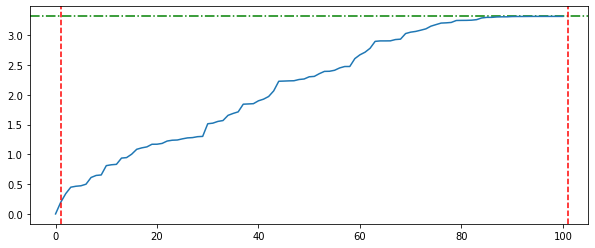


Test: ([(7, 7), (22, 22)], [40, 100])
141


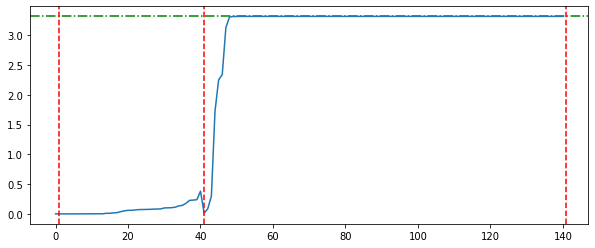


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


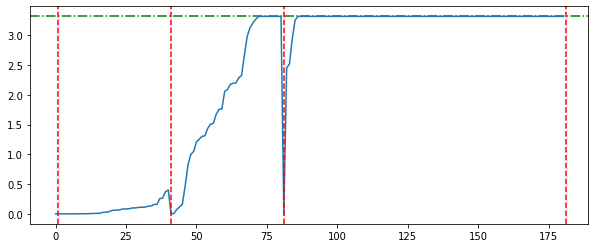


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


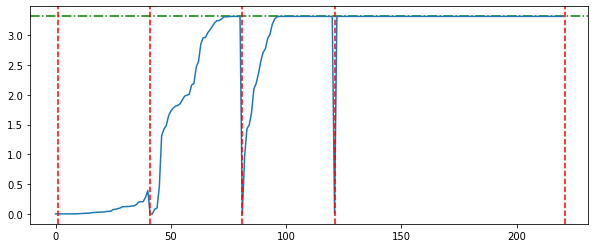


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


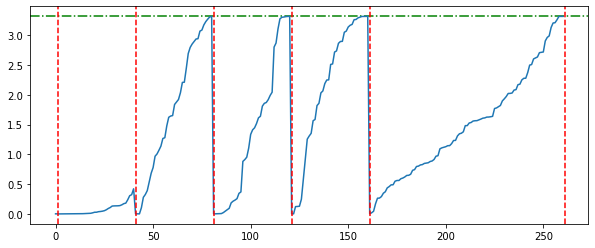



################## Random Labels ###################

Running Test: ([(28, 28)], [100])
Running Test: ([(7, 7), (22, 22)], [40, 100])
Running Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
Running Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
layers: 1 | 10.85/9.98 -> 10.85/9.98 | ([(28, 28)], [100])
layers: 2 | 10.31/10.02 -> 10.31/10.02 | ([(7, 7), (22, 22)], [40, 100])
layers: 3 | 10.41/10.44 -> 10.41/10.44 | ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
layers: 4 | 10.15/10.14 -> 10.15/10.14 | ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
layers: 5 | 10.16/10.13 -> 10.16/10.13 | ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])

Test: ([(28, 28)], [100])
101


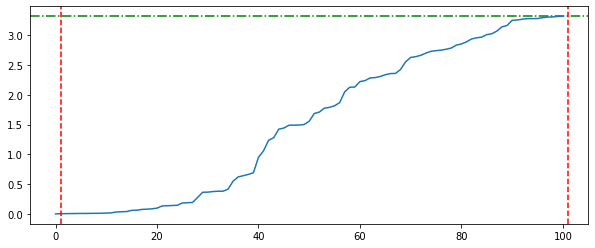


Test: ([(7, 7), (22, 22)], [40, 100])
141


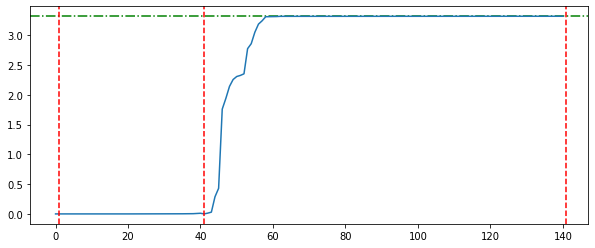


Test: ([(7, 7), (7, 7), (16, 16)], [40, 40, 100])
181


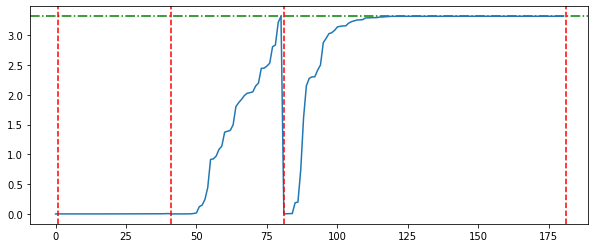


Test: ([(7, 7), (7, 7), (7, 7), (10, 10)], [40, 40, 40, 100])
221


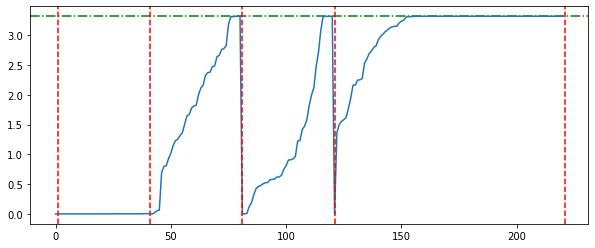


Test: ([(7, 7), (7, 7), (7, 7), (7, 7), (4, 4)], [40, 40, 40, 40, 100])
261


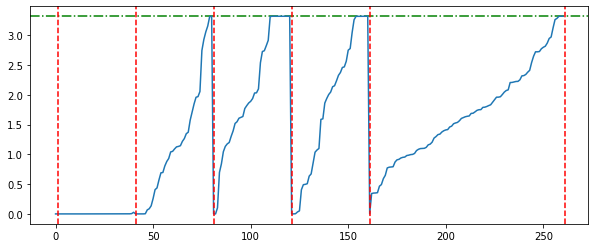

In [21]:
# Test 9b - don't train the network
print("\n\n################## Normal Labels ###################\n")
testresults, models = runMLTests(tests, train20, test20, epochs=0, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, test20, pool=True, maxgain=maxgain)

print("\n\n################## Random Labels ###################\n")

testresults, models = runMLTests(tests, Rtrain, Rtest, epochs=0, eta=eta, device='cuda:4')
pptestresults(tests, testresults)

maxgain = -np.log2(0.1)
analyzeModels(tests, models, Rtest, pool=True, maxgain=maxgain)

In [ ]:
# Test 10 - Association areas.
# We are going to need to construct a new network architecture for this
# I want to try clustering with the label at all levels...
# This will require re-writing the CEMMB class to allow this side information

class ACEMMB(Convolutor):
    def __init__(self, in_size, filters, kernel_size, stride=1, eta=0.95, FF=None):
        super().__init__(in_size, filters, kernel_size, stride=stride)
        self.Process = EMMB(self.D, filters, eta=eta, FF=FF)
        
        self.register_buffer('M', torch.tensor(filters))
        
    def forward(self, x):
        (bs,c,h,w) = x.shape
        x1 = self.unfold_input(x)
        yuf = self.Process(x1)
        y = self.fold_forward(yuf, bs)
        return y
    
    def learn(self, x):
        x1 = self.unfold_input(x)
        self.Process.learn(x1)
    
    def params(self, reshape=False, sort=True):
        (pi, mu) =  self.Process.params(sort)
        mss = mu.shape
        if (reshape):
            mss = (self.F, self.C)+self.K
        return (pi, mu.view(mss))

class AMLMM(nn.Module):
    def __init__(self, kernels, Ms, img_shape, eta, device):
        super().__init__()
        
        self.kernels = kernels
        self.Ms = Ms
        self.layers = nn.ModuleList()
        self.M = Ms[-1] # number of modes for final layer
        
        for i in range(len(kernels)):
            self.layers.append(CEMMB(img_shape, Ms[i], kernels[i], eta=eta).to(device))
            img_shape = self.layers[-1].output_shape
    
    def forward(self, data, full=False):
        Ys = [data]
        for l in self.layers:
            Ys.append(l(Ys[-1]))
        if (full):
            return Ys
        else:
            return Ys[-1]
        
    def learn(self, data):
        Ys = self.forward(data, full=True)
        for i in range(len(self.layers)):
            self.layers[i].learn(Ys[i])
            
    def params(self):
        return [l.params() for l in self.layers]

In [ ]:
# Can I reconstruct the higher level means?

cmodel = models[-1]
ps = cmodel.params()
full = None
for i in range(len(ps)-1, -1, -1):
    print ("Layer {}".format(i))
    (pi, mu) = ps[i]
    print (pi.shape, mu.shape)
    if (full is None):
        full = 

# Experimental sector/ Old stuff
The below section contains old code, small random experiments none of this is guaranteed to work... it will probably be deleted

In [8]:
def responsibility(x, pi, mu, reduce=True, verbose=False):
    with silence(not verbose):
        x = x.unsqueeze(1)
        print ('x', torch.isnan(x).sum()>0)
        print ('pi', torch.isnan(pi).sum()>0)
        print ('mu', torch.isnan(mu).sum()>0)
        # Negative Log Liklihood of the multinoulis
        logpi = torch.log(pi+1e-18)
        print ('logpi',torch.isnan(logpi).sum()>0)
        logmu = torch.log(mu+1e-18)
        print ('logmu',torch.isnan(logmu).sum()>0)
        logommu = torch.log(1-mu+1e-18)
        print ('logommu',torch.isnan(logommu).sum()>0)
        mix_log_probs = (logpi + (x*logmu + (1-x)*logommu).sum(-1))
        print ('mix_log_probs', torch.isnan(mix_log_probs).sum()>0)
        resp = F.softmax(mix_log_probs, dim=-1)
        print ('resp', torch.isnan(resp).sum()>0)
    return resp

tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250])


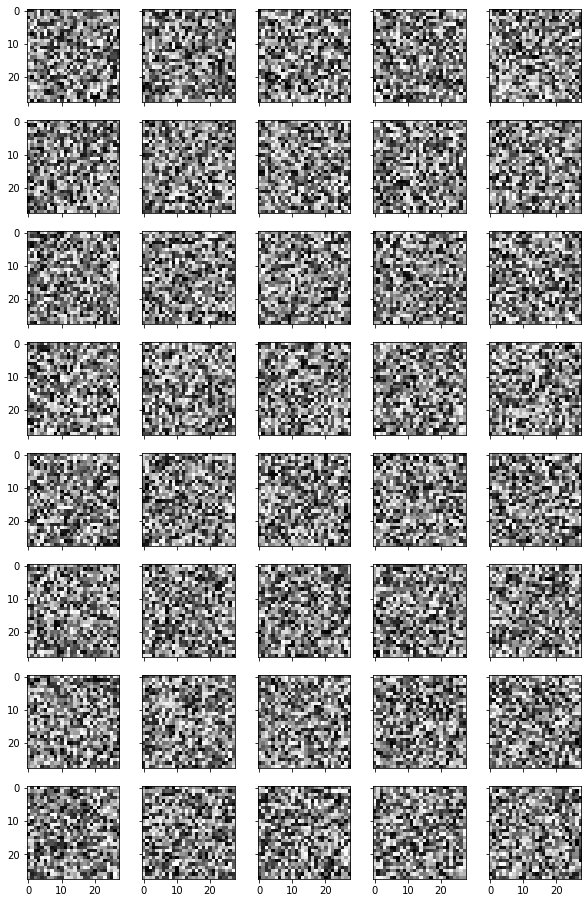

tensor([4.8080e-01, 3.2766e-01, 5.6726e-02, 3.7544e-02, 3.2317e-02, 1.7144e-02,
        1.5586e-02, 1.3139e-02, 1.1116e-02, 2.7177e-03, 1.3669e-03, 1.0595e-03,
        9.1512e-04, 8.0424e-04, 2.5600e-04, 2.3688e-04, 1.5723e-04, 9.9320e-05,
        7.5869e-05, 7.5712e-05, 6.0166e-05, 5.8430e-05, 3.3473e-05, 2.9285e-05,
        8.0049e-06, 2.1344e-06, 1.3886e-06, 1.2160e-06, 1.4484e-07, 5.8932e-08,
        5.3347e-08, 8.4085e-11, 7.9248e-11, 4.8990e-12, 3.9542e-13, 1.1926e-13,
        2.6535e-14, 1.6711e-18, 2.6075e-24, 2.3901e-29])


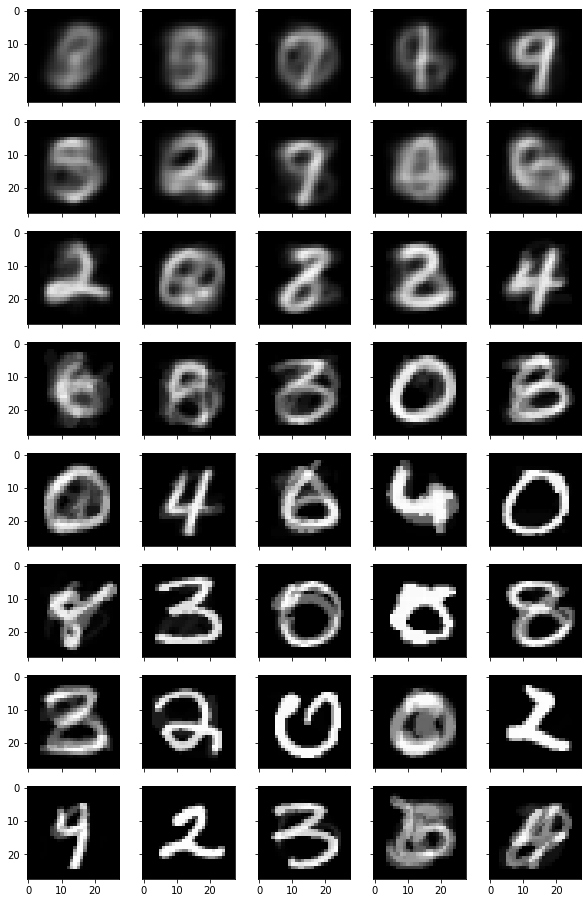

tensor([2.9886e-01, 1.0765e-01, 1.0341e-01, 8.4822e-02, 5.8998e-02, 5.7609e-02,
        3.9138e-02, 3.3717e-02, 3.3667e-02, 2.8005e-02, 2.5834e-02, 1.8350e-02,
        1.7026e-02, 1.4848e-02, 1.4234e-02, 1.3936e-02, 9.4525e-03, 8.3261e-03,
        7.6272e-03, 6.2702e-03, 3.1823e-03, 2.9399e-03, 2.4124e-03, 2.3531e-03,
        2.0405e-03, 1.4668e-03, 1.1339e-03, 8.9432e-04, 6.7647e-04, 2.6621e-04,
        2.2952e-04, 2.1138e-04, 1.6157e-04, 1.1328e-04, 5.0000e-05, 1.6667e-05,
        1.6667e-05, 1.6667e-05, 1.6667e-05, 1.6667e-05])


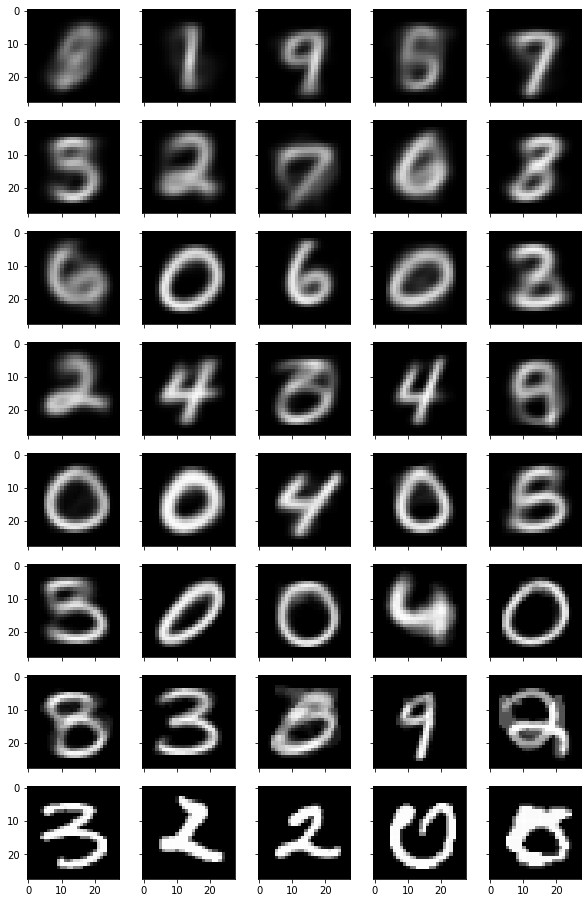

tensor([1.6974e-01, 1.0567e-01, 9.2528e-02, 7.4493e-02, 6.8471e-02, 5.2928e-02,
        4.9643e-02, 4.2520e-02, 3.8974e-02, 3.1545e-02, 3.0870e-02, 2.7571e-02,
        2.3303e-02, 2.0869e-02, 2.0151e-02, 1.8591e-02, 1.7313e-02, 1.6003e-02,
        1.5864e-02, 1.1049e-02, 1.0815e-02, 8.6809e-03, 8.1965e-03, 7.9879e-03,
        7.9792e-03, 6.0984e-03, 5.8896e-03, 3.7686e-03, 3.1362e-03, 2.9252e-03,
        2.3217e-03, 1.9172e-03, 1.2295e-03, 8.1147e-04, 6.6484e-05, 1.6667e-05,
        1.6667e-05, 1.6667e-05, 1.6667e-05, 1.6667e-05])


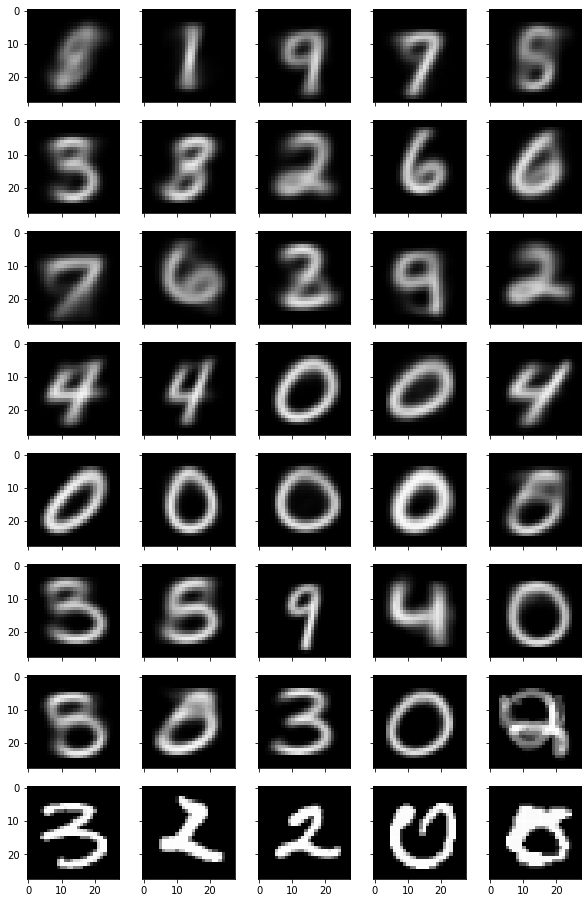

tensor([1.2221e-01, 9.8102e-02, 7.6098e-02, 7.1444e-02, 6.9950e-02, 5.3598e-02,
        4.4996e-02, 4.4473e-02, 4.2514e-02, 3.1751e-02, 2.9593e-02, 2.9262e-02,
        2.9195e-02, 2.6687e-02, 2.3568e-02, 2.1806e-02, 2.1089e-02, 1.7969e-02,
        1.5171e-02, 1.4449e-02, 1.3580e-02, 1.3195e-02, 1.2266e-02, 1.1523e-02,
        1.0448e-02, 9.1501e-03, 9.1097e-03, 8.8155e-03, 6.3804e-03, 6.1156e-03,
        5.8920e-03, 4.3565e-03, 3.5086e-03, 1.5742e-03, 7.4331e-05, 1.6667e-05,
        1.6667e-05, 1.6667e-05, 1.6667e-05, 1.6667e-05])


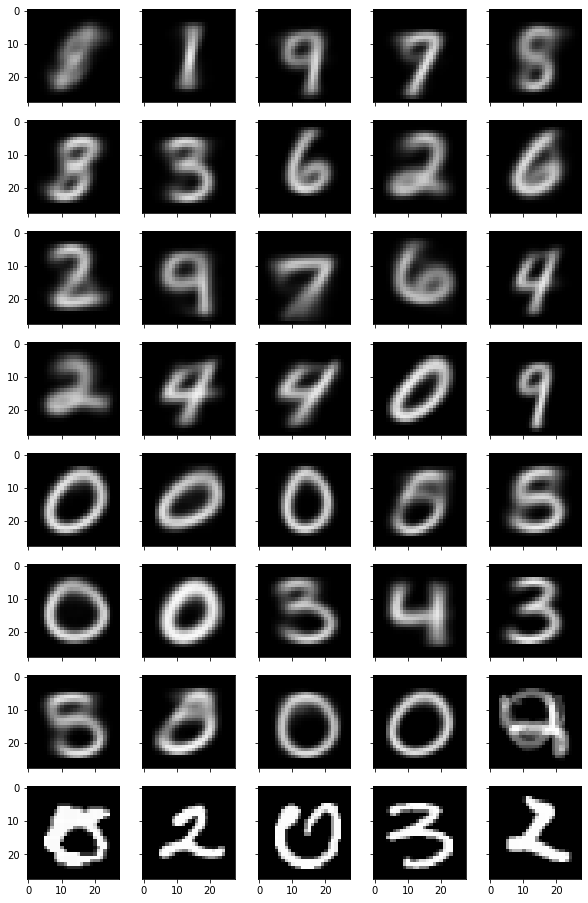

KeyboardInterrupt: 

In [9]:
# This cell demonstrates how to do offline EM clustering
# It it kept solely for historical reference

M = 40
D = 784
epochs = 10

mu = torch.rand((1,M,D))
pi = torch.ones((1,M))/M
plotMeans(pi, mu)

# E step: calculates the responsibility of each mode for each point
# M step: calculates the pis and mus

# Since we are doing this with batches we need to accumulate the statistics
for e in range(epochs):
    newmu = torch.zeros((1,M,D))
    rk = torch.zeros((1,M))
    N = 0
    for (data, label) in train:
        data = data.view(-1,D)
        N += data.shape[0]
        rik = responsibility(data.view(-1, D), pi, mu)
        if (torch.isnan(rik).sum()>0):
            responsibility(data.view(-1,D), pi, mu, verbose=True)
            raise ValueError("NaN Found")
        rk += rik.sum(0, keepdim=True)
        # rik:  (BS, M) -> (BS, M, 1)
        # data: (BS, D) -> (BS, 1, D)
        newmu += (rik.unsqueeze(-1)*data.unsqueeze(1)).sum(0, keepdim=True)
        
    pi = rk/N
    mu = newmu/rk.unsqueeze(-1)

    plotMeans(pi, mu)
        
        


In [ ]:
# THis is the online version

M = 40
D = 784
epochs = 5

eta = 0.95

mu = torch.rand((1,M,D))
pi = torch.ones((1,M))/M
# plotMeans(pi, mu)

# E step: calculates the responsibility of each mode for each point
# M step: calculates the pis and mus
c = 0
# Since we are doing this with batches we need to accumulate the statistics
for e in range(epochs):
    for (data, label) in train:
        data = data.view(-1,D)
        N += data.shape[0]
        rik = responsibility(data.view(-1, D), pi, mu)
        if (torch.isnan(rik).sum()>0):
            print (mu)
            responsibility(data.view(-1,D), pi, mu, verbose=True)
            raise ValueError("NaN Found")
        rk = rik.sum(0, keepdim=True)
        # rik:  (BS, M) -> (BS, M, 1)
        # data: (BS, D) -> (BS, 1, D)
        newmu = (rik.unsqueeze(-1)*data.unsqueeze(1)).sum(0, keepdim=True)/(rk.unsqueeze(-1)+1e-18)
        newpi = rk/data.shape[0]
        
        # The update
        pi = eta*pi + (1-eta)*newpi
        mu = eta*mu + (1-eta)*newmu
#         print (newmu)
#         print (mu)
        
#     pi = 
#     mu = newmu/rk.unsqueeze(-1)
#         if (c%1000 == 0):
    plotMeans(pi, mu)
#         c += 1
        
        


In [ ]:
def responsibility(x, pi, mu, raw=False, verbose=False):
    with silence(not verbose):
        x = x.unsqueeze(1)
        print ('x', torch.isnan(x).sum()>0)
        print ('pi', torch.isnan(pi).sum()>0)
        print ('mu', torch.isnan(mu).sum()>0)
        # Negative Log Liklihood of the multinoulis
        logpi = torch.log(pi+1e-18)
        print ('logpi',torch.isnan(logpi).sum()>0)
        logmu = torch.log(mu+1e-18)
        print ('logmu',torch.isnan(logmu).sum()>0)
        logommu = torch.log(1-mu+1e-18)
        print ('logommu',torch.isnan(logommu).sum()>0)
        mix_log_probs = (logpi + (x*logmu + (1-x)*logommu).sum(-1))
        print ('mix_log_probs', torch.isnan(mix_log_probs).sum()>0)
        resp = F.softmax(mix_log_probs, dim=-1)
        print ('resp', torch.isnan(resp).sum()>0)
    
    if (raw):
        return mix_log_probs
    return resp

In [ ]:
BS = 1

# Training dataset
train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

In [ ]:
# Here I was attempting to figure out a way to make it more reliable mostly by
# automatically overwritting a node if it was not being used and a new sample was not
# well fit by an existing modes...

# This problem occurs when the batch size goes to 1 (the most online version)

# This should be explored further at a later date.


M = 20
D = 784
epochs = 5


eta = 0.99
print (0.5/M)
avgmin = None

mu = torch.rand((1,M,D))
pi = torch.ones((1,M))/M
# plotMeans(pi, mu)

# E step: calculates the responsibility of each mode for each point
# M step: calculates the pis and mus
c = 0
# Since we are doing this with batches we need to accumulate the statistics
for e in range(epochs):
    for (data, label) in train:
        data = data.view(-1,D)
        N += data.shape[0]
        
        if (torch.isnan(rik).sum()>0):
            print (mu)
            responsibility(data, pi, mu, verbose=True)
            raise ValueError("NaN Found")
            
        
        confidence = torch.max(responsibility(data, pi, mu)).item()
#         minraw = torch.max(responsibility(data, pi, mu, raw=True)).item()
#         print (confidence)
#         if (avgmin is None):
#             avgmin = minraw
#         else:
#             avgmin = 0.9*avgmin + 0.1*minraw
        
        # This is finding the least used mode but not detecting if
        #current sample doesn't already fit a mode "ok"
        minpi, owm = torch.min(pi, dim=1)
        if (minpi < 0.5/M and confidence<0.5):
            # overwrite the least used mode
#             _, owm = torch.min(pi, dim=1)
            mu[0,owm[0]] = data
        
        rik = responsibility(data, pi, mu)
        rk = rik.sum(0, keepdim=True)
        # rik:  (BS, M) -> (BS, M, 1)
        # data: (BS, D) -> (BS, 1, D)
        newmu = (rik.unsqueeze(-1)*data.unsqueeze(1)).sum(0, keepdim=True)/(rk.unsqueeze(-1)+1e-18)
        newpi = rk/data.shape[0]

        # The update
        pi = eta*pi + (1-eta)*newpi
        mu = eta*mu + (1-eta)*newmu
#         print (newmu)
#         print (mu)
        
#     pi = 
#     mu = newmu/rk.unsqueeze(-1)
#         if (c%1000 == 0):
        plotMeans(pi, mu)
#         c += 1
        
        
